# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [ ]:
#Code of S1852913, S2446971

In [1]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import time
import numpy as np
# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
import matplotlib.pyplot as plt

# ... (add your code to create WFSTs and Viterbi Decoder)

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
                
    for i in range(1,6):
        state_table.add_symbol('{}_{}'.format('sil', i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

def generate_phone_wfst(f, start_state, phone, n, sl_weight, trans_weight):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    loop_weight = fst.Weight('log', -math.log(sl_weight))
    next_weight = fst.Weight('log', -math.log(trans_weight)) 
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        f.add_arc(current_state, fst.Arc(in_label, 0, loop_weight, current_state))
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, 0, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state


def generate_word_wfst(word, sl_weight, trans_weight):
    """ Generate a WFST for any word in the lexicon, composed of 3-state phone WFSTs.
        This will currently output word labels.  
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        word (str): the word to generate
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst('log')
    
    # create the start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        
        loop_weight = fst.Weight('log', -math.log(sl_weight)) # weight to next stat
        next_weight = fst.Weight('log', -math.log(trans_weight)) # weight to next stat
        current_state = generate_phone_wfst(f, current_state, phone, 3, loop_weight, next_weight)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f

state_table.write_text('state_table.txt')
print(open('state_table.txt').read())

<eps>	0
ey_1	1
ey_2	2
ey_3	3
ah_1	4
ah_2	5
ah_3	6
v_1	7
v_2	8
v_3	9
p_1	10
p_2	11
p_3	12
eh_1	13
eh_2	14
eh_3	15
k_1	16
k_2	17
k_3	18
er_1	19
er_2	20
er_3	21
z_1	22
z_2	23
z_3	24
iy_1	25
iy_2	26
iy_3	27
t_1	28
t_2	29
t_3	30
ih_1	31
ih_2	32
ih_3	33
l_1	34
l_2	35
l_3	36
d_1	37
d_2	38
d_3	39
ay_1	40
ay_2	41
ay_3	42
dh_1	43
dh_2	44
dh_3	45
w_1	46
w_2	47
w_3	48
r_1	49
r_2	50
r_3	51
sil_1	52
sil_2	53
sil_3	54
sil_4	55
sil_5	56



In [2]:
#VITERBI NO Pruning
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name): #Need to add Beam Search Parameter here, beam_width = ...
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
        
        self.forward_computations = 0
        

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        self.V[0][self.f.start()] = 0.0

        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:

            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        self.V[t][j] = self.V[t][i] + float(arc.weight)

                        self.B[t][j] = self.B[t][i] 

                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        
                        #Increment the forward computation counter
                        self.forward_computations += 1
                        
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                    else:
                        self.forward_computations += 1

                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)
    
    
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription
    

In [3]:
def create_wfst(sl_weight, trans_weight):
    f = fst.Fst('log')
    # create a single start state
    
    start_state = f.add_state()
    f.set_start(start_state)
    
    next_weight = fst.Weight('log', -math.log(trans_weight))
    
    for word, phones in lex.items():

        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, next_weight, current_state))
        for phone in phones:

            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
    
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, word_table.find(word), next_weight, start_state))
        
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
    
        
    from subprocess import check_call
    from IPython.display import Image
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
    Image(filename='tmp.png')
    
    return f


In [4]:
def count_arcs(f):
    arc_count = 0
    for state in f.states():
        for arc in f.arcs(state):
            arc_count +=1
    return arc_count

## Baseline ##

In [8]:
f = create_wfst(0.5, 0.5)


decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file)
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.732768720365835
2.1925789177792625
Sub, Del, Ins: 2.2044025157232703 0.25157232704402516 2.7641509433962264
Avg Number of forward computations: 111970.16981132075
decode_time 2.1925789177792625
backtrace_time 0.0002482387254822929
///////////////


## Silent ##

In [8]:
def generate_silent_phone_wfst(f, start_state, phone, n, sl_weight, trans_weight):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        sl_weight (float): self-loop weight for each state
        trans_weight (float): transition weight between states
        
    Returns:
        the final state of the FST
    """
    
    loop_weight = fst.Weight('log', -math.log(sl_weight))
    next_weight = fst.Weight('log', -math.log(trans_weight)) 
    states = []
    
    # create states
    for i in range(n):
        if i == 0:
            states.append(start_state)
        else:
            states.append(f.add_state())
    
    # add arcs to states
    for i in range(1, n):
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # add arcs for ergodic structure
        if i != 1 and i != n:
            for j in range(1, n):
                f.add_arc(states[i-1], fst.Arc(in_label, 0, next_weight, states[j]))
        
        # add arcs for non-ergodic structure
        else:
            f.add_arc(states[i-1], fst.Arc(in_label, 0, next_weight, states[i]))
        
        # set final state
        if i == n-1:
            f.set_final(states[i])
        
    return states[i]

def create_wfst_silent(sl_weight, trans_weight, sil_weight):
    f = fst.Fst('log')
    # create a single start state
    
    start_state = f.add_state()
    silent_state = f.add_state()
    f.set_start(start_state)
    
    next_weight = fst.Weight('log', -math.log(trans_weight))
    silent_weight = fst.Weight('log', -math.log(sil_weight))
    f.add_arc(start_state, fst.Arc(0, 0, silent_weight, silent_state))
    
    for word, phones in lex.items():
        print(word)
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, next_weight, current_state))
        for phone in phones:

            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
    
        
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, word_table.find(word), next_weight, start_state))    
    
    
    silent_state = generate_silent_phone_wfst(f, silent_state, 'sil', 5, sl_weight, trans_weight)
    f.set_final(silent_state)
    f.add_arc(silent_state, fst.Arc(0, 0, next_weight, start_state))
    
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
    
        
    from subprocess import check_call
    from IPython.display import Image
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
    Image(filename='tmp.png')
    
    return f

In [5]:
f = create_wfst_silent(0.5,0.5,0.5)


decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file)
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    print('trans:',transcription)
    print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

a
of
peck
peppers
peter
picked
pickled
piper
the
where's
trans: a pickled piper of peter
words: of pickled piper the of peter
trans: where's peter
words: where's peter
trans: peter picked a peck
words: peter peck of peck
trans: where's the peppers
words: where's the peppers
trans: the piper pickled peppers
words: the piper pickled peppers
trans: peter piper picked a peck of pickled peppers
words: a of of pickled peck of pickled a of where's
trans: a peck of pickled peppers peter piper picked
words: the peck a pickled pickled picked piper picked
trans: where's the peck of pickled peppers peter piper picked
words: where's of peck of the pickled picked where's pickled a peck
trans: peter picked a peck of pickled peppers
words: peter picked peck of pickled peppers
trans: where's the peck of pickled peppers
words: where's peck picked where's
trans: pickled peppers peck peter piper
words: pickled peppers peck peter piper
trans: peter piper picked a peck of pickled peppers where's the peck of

trans: where's the pickled peppers peter piper picked
words: where's of peck of peppers peter peter picked
trans: peter piper picked a peck of pickled peppers
words: the where's of of piper picked the pickled peter peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's piper where's peter peck peppers peter piper picked
trans: peter piper picked a peck of pickled peppers
words: the picked of piper of piper where's pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's the piper pickled peter peck where's the where's picked
trans: peter piper picked a peck of pickled peppers
words: of peter peppers peppers of peck of pickled peppers
trans: where's the peck of pickled peppers
words: picked a where's the piper a of pickled peter
trans: peter piper picked
words: the the pickled piper of peck picked
trans: peck of pickled peppers
words: the a of pickled the peter of
trans: pickled peppers peter piper picked
words: pickled t

trans: peter picked peppers
words: peter picked where's
trans: the peck of peter piper peppers
words: where's peck of peter piper picked where's
trans: peter picked the piper
words: peter peck picked the piper the
trans: peppers pickled peter piper
words: peck where's pickled peter piper the
trans: picked a peter piper pickled peppers peck
words: peck picked of peter piper peck pickled peck where's peck
trans: peter piper where's a pickled peppers picked the peck of peppers
words: peter piper where's of pickled peppers picked of peck of peppers
trans: the peck of pickled peppers
words: the peck of pickled peppers
trans: a pickled peter peck of piper peppers
words: of pickled peter peck of piper peppers
trans: peppers peter where's a peck
words: peck where's peter where's of peck
trans: piper pickled a picked peter
words: piper pickled peck picked peter
trans: the peppers piper peter picked of pickled peppers peter picked
words: the peck picked peck peter of picked of pickled peppers pe

trans: peter piper picked a peck of pickled peppers
words: peter piper of picked peck pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's the peck of pickled peppers peter piper picked
trans: peter piper picked pickled peppers
words: peter piper picked pickled peppers
trans: where's peter piper
words: where's a of piper
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: picked of piper picked peck of pickled peppers where's of peck pickled of picked peter piper picked
trans: a peck of picked peppers peter piper pickled
words: of peck of picked of peppers peter piper pickled
trans: peter piper picked peppers
words: the of piper peck picked peppers
trans: where's peter piper
words: where's a the piper
trans: the peppers peter pickled
words: the peck where's picked of pickled
trans: piper picked the peck of peppers
words: piper of picked the peck of of where's
trans: peter piper
words: 

trans: piper picked a peck of pickled peppers where's the
words: piper picked of peck of pickled peppers where's pickled of
trans: peter piper picked a peck of pickled peppers where's the peck of pickled pickled peppers peter piper picked
words: picked piper of a picked a pickled where's where's the peck of pickled where's a picked piper of picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled pickled peppers peter piper picked
words: picked piper of a the peck of the a of where's where's of a of the where's where's pickled picked
trans: peter pickled peppers where's the piper peter
words: peter picked peppers where's the of of picked picked
trans: peter peter peter picked picked picked
words: picked of peter peter peck picked
trans: peter piper picked a peck of pickled peppers
words: peter picked of picked peck of peck of pickled peppers
trans: peter piper picked peppers
words: peter of of of picked peck peppers
trans: peter piper picked pickled pepper

## Unigram ##

In [9]:
#Creating WFST_Unigram
passage = "Peter Piper picked a peck of pickled peppers. Where's the peck of pickled peppers Peter Piper picked"
passage = passage.replace(".", "")
passage = passage.lower()

unigrams = passage.split()
unigram_counts = {}

for unigram in unigrams:
    if unigram not in unigram_counts:
        unigram_counts[unigram] = 1
    else:
        unigram_counts[unigram] += 1


total_unigrams = sum(unigram_counts.values())

def create_wfst_unigram(sl_weight, trans_weight):
    f = fst.Fst('log')
    # create a single start state
   
    start_state = f.add_state()
    f.set_start(start_state)
   
    for word, phones in lex.items():
        current_state = f.add_state()
       
        word_probs = unigram_counts[word]/total_unigrams
        next_word_weight = fst.Weight('log', -math.log(word_probs))
       
        f.add_arc(start_state, fst.Arc(0, 0, next_word_weight, current_state))
        for phone in phones:
            next_weight = fst.Weight('log', -math.log(trans_weight))
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
       
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, word_table.find(word), next_weight, start_state))  
   
       
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
   
   
    return f

In [8]:
f = create_wfst_unigram(0.5, 0.5)


decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file)
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.7042571951007024
2.2336386254748457
Sub, Del, Ins: 2.1635220125786163 0.2861635220125786 2.5849056603773586
Avg Number of forward computations: 111970.16981132075
decode_time 2.2336386254748457
backtrace_time 0.0002551138775903474
///////////////


## Unigram Silent + Determinise ##

In [10]:
#Creating Unigram_Silent
passage = "Peter Piper picked a peck of pickled peppers. Where's the peck of pickled peppers Peter Piper picked"
passage = passage.replace(".", "")
passage = passage.lower()

unigrams = passage.split()
unigram_counts = {}

for unigram in unigrams:
    if unigram not in unigram_counts:
        unigram_counts[unigram] = 1
    else:
        unigram_counts[unigram] += 1

space_count = 0
for char in passage:
    if char.isspace():
        space_count +=1

unigram_counts[" "] = space_count

total_unigrams = sum(unigram_counts.values())
print(unigram_counts)

def create_wfst_unigram_silent(sl_weight, trans_weight, final_weight):
    f = fst.Fst('log')
    # create a single start state
   
    start_state = f.add_state()
    f.set_start(start_state)
    silent_state = f.add_state()
    sil_weight = unigram_counts[" "]/total_unigrams
    silent_weight = fst.Weight('log', -math.log(sil_weight))
    next_weight = fst.Weight('log', -math.log(final_weight))
   
    for word, phones in lex.items():
        current_state = f.add_state()
       
        word_probs = unigram_counts[word]/total_unigrams
        next_word_weight = fst.Weight('log', -math.log(word_probs))
       
        f.add_arc(start_state, fst.Arc(0, 0, next_word_weight, current_state))
        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
       
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, word_table.find(word), fst.Weight('log', -math.log(trans_weight)), start_state))  
   
    f.add_arc(start_state, fst.Arc(0, 0, silent_weight, silent_state))
    silent_state = generate_silent_phone_wfst(f, silent_state, 'sil', 5, sl_weight, trans_weight)
    f.set_final(silent_state)
    f.add_arc(silent_state, fst.Arc(0, 0, fst.Weight('log', -math.log(trans_weight)), start_state))
       
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)

   
    return f


{'peter': 2, 'piper': 2, 'picked': 2, 'a': 1, 'peck': 2, 'of': 2, 'pickled': 2, 'peppers': 2, "where's": 1, 'the': 1, ' ': 16}


In [7]:
f = create_wfst_unigram_silent(0.5, 0.5, 0.5)


decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file)
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)

    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)


print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.5139432514293784
2.3620494454161927
Sub, Del, Ins: 2.0849056603773586 0.3333333333333333 1.430817610062893
Avg Number of forward computations: 119343.81132075471
decode_time 2.3620494454161927
backtrace_time 0.0002575467967387265
///////////////


In [8]:
#Unigram Silent with Determinise
f = create_wfst_unigram_silent(0.5, 0.5, 0.5)
f = fst.determinize(f)

decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file)
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    print('trans:',transcription)
    print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

trans: a pickled piper of peter
words: of pickled piper the of peter
trans: where's peter
words: where's peter
trans: peter picked a peck
words: peter picked peck
trans: where's the peppers
words: where's the peppers
trans: the piper pickled peppers
words: the piper pickled peppers
trans: peter piper picked a peck of pickled peppers
words: a of of pickled peck of pickled a of where's
trans: a peck of pickled peppers peter piper picked
words: the peck pickled pickled picked piper picked
trans: where's the peck of pickled peppers peter piper picked
words: where's of peck of the pickled picked where's pickled a peck
trans: peter picked a peck of pickled peppers
words: peter picked peck of pickled peppers
trans: where's the peck of pickled peppers
words: where's peck picked where's
trans: pickled peppers peck peter piper
words: pickled peppers peck peter piper
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peter piper picke

trans: peter piper picked a peck of pickled peppers
words: the where's of peter picked the pickled peter peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's piper where's peter peck peppers peter piper picked
trans: peter piper picked a peck of pickled peppers
words: the picked of piper of piper where's pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's the piper pickled peter peck where's the where's picked
trans: peter piper picked a peck of pickled peppers
words: of peter peppers peppers of peck of pickled peppers
trans: where's the peck of pickled peppers
words: picked a where's the piper a of pickled peter
trans: peter piper picked
words: the the pickled piper of peck picked
trans: peck of pickled peppers
words: the a of pickled the peter of
trans: pickled peppers peter piper picked
words: pickled the of of peter picked the pickled picked
trans: a peck of pickled peppers where's the peck of pickled peppers


trans: peter picked the piper
words: peter peck picked the piper the
trans: peppers pickled peter piper
words: peck where's pickled peter piper
trans: picked a peter piper pickled peppers peck
words: peck picked of peter piper pickled peck where's peck
trans: peter piper where's a pickled peppers picked the peck of peppers
words: peter piper where's of pickled peppers picked of peck of peppers
trans: the peck of pickled peppers
words: the peck of pickled peppers
trans: a pickled peter peck of piper peppers
words: of pickled peter peck of piper peppers
trans: peppers peter where's a peck
words: peppers peter where's of peck
trans: piper pickled a picked peter
words: piper pickled peck picked peter
trans: the peppers piper peter picked of pickled peppers peter picked
words: the peck picked peck peter of picked of pickled peppers peter picked
trans: where's peter piper of the pickled peppers
words: the where's peter piper of the pickled peppers
trans: the peck of piper picked peppers pick

trans: peter piper picked pickled peppers
words: peter piper picked pickled peppers
trans: where's peter piper
words: where's a of piper
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: picked of piper picked peck of pickled peppers where's of peck pickled of picked peter piper picked
trans: a peck of picked peppers peter piper pickled
words: of peck of picked of peppers peter piper pickled
trans: peter piper picked peppers
words: the of piper peck picked peppers
trans: where's peter piper
words: where's a the piper
trans: the peppers peter pickled
words: the peck where's picked of pickled
trans: piper picked the peck of peppers
words: piper of picked the peck of of where's
trans: peter piper
words: peter piper
trans: pickled peppers
words: the of picked where's
trans: peter piper picked a peck of pickled peppers
words: the piper picked pickled picked picked where's
trans: where's the peck of pickled peppers peter piper p

trans: peter piper picked a peck of pickled peppers where's the peck of pickled pickled peppers peter piper picked
words: picked piper of a the peck of a of where's where's of a of the where's where's pickled picked
trans: peter pickled peppers where's the piper peter
words: peter picked peppers where's the of of picked picked
trans: peter peter peter picked picked picked
words: picked peter peter peck picked
trans: peter piper picked a peck of pickled peppers
words: peter picked of picked peck of peck of pickled peppers
trans: peter piper picked peppers
words: peter of of of picked peck peppers
trans: peter piper picked pickled peppers
words: picked of of a picked pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's of pickled pickled peppers peter peter picked
trans: where's the peck of peppers peter piper picked
words: where's of peck of peppers peter of piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickl

## Unigram Silent Tuned ##

In [10]:
#Without determinize
f = create_wfst_unigram_silent(0.5, 0.2625, 0.5)


decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file)
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.4853766726963179
2.420398328289296
Sub, Del, Ins: 2.050314465408805 0.39308176100628933 1.229559748427673
Avg Number of forward computations: 119343.81132075471
decode_time 2.420398328289296
backtrace_time 0.00025408297964611893
///////////////


## Unigram Silent Tuned With Pruning ##

In [11]:
#Viterbi Decoder WITH PRUNING (threshold - active) (percentage pruning #commented out#)
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name, beam_width =100): #Need to add Beam Search Parameter here, beam_width = ...
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
        
        self.forward_computations = 0
        
        self.beam_width = beam_width  # Added beam_width as a class member variable

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
    
        self.V[0][self.f.start()] = 0.0

        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            

            i = states_to_traverse.pop(0)   

            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):

                        self.V[t][j] = self.V[t][i] + float(arc.weight)

                        self.B[t][j] = self.B[t][i] 

                        
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        
                        #Increment the forward computation counter
                        self.forward_computations += 1
                        
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                    else:
                        self.forward_computations += 1
                    

        min_cost = min(self.V[t])
        for j in range(len(self.V[t])):

            if self.V[t][j] - min_cost > -math.log(self.beam_width):
                self.V[t][j] = self.NLL_ZERO
                
                
#     def forward_step_beam(self, t):
#         for i in self.f.states():
           
#             if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
               
#                 for arc in self.f.arcs(i):
                   
#                     if arc.ilabel != 0: # <eps> transitions don't emit an observation
#                         j = arc.nextstate
#                         tp = float(arc.weight)  # transition prob
#                         ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                       
#                         #Increment the forward computation counter
#                         self.forward_computations += 1
                       
#                         prob = tp + ep + self.V[t-1][i] # they're logs
#                         if prob < self.V[t][j]:
#                             self.V[t][j] = prob
#                             self.B[t][j] = i
                           
#                             # store the output labels encountered too
#                             if arc.olabel !=0:
#                                 self.W[t][j] = [arc.olabel]
#                             else:
#                                 self.W[t][j] = []
#                     else:
#                         self.forward_computations += 1

#         sorted_list = sorted(self.V[t], reverse=False)
#         top_x = sorted_list[:round(len(sorted_list)*self.beam_width)]
#         self.V[t] = [item if item in top_x else self.NLL_ZERO for item in self.V[t]]

                
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)
    
    
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription
    

In [12]:
#Without determinize
f = create_wfst_unigram_silent(0.5, 0.2625, 0.5)


decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file, 1e-41) #Added threshold pruning parameter
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    #print('trans:',transcription)
    #print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count
#         lengths_averages[word_count][0] += 1
#         lengths_averages[word_count][1] += WER

#             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)

#finer_grained.append(averageWER)
#results.append(averageWER)
#     all_wer_length = []
#     for [count, wer] in lengths_averages:
#         if count == 0:
#             all_wer_length.append(0)
#         else:
#             all_wer_length.append(wer/count)
#     print(all_wer_length)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.4853766726963179
2.198931211195652
Sub, Del, Ins: 2.050314465408805 0.39308176100628933 1.229559748427673
Avg Number of forward computations: 107803.33333333333
decode_time 2.198931211195652
backtrace_time 0.00022523733055066763
///////////////


In [13]:
#With determinize
f = create_wfst_unigram_silent(0.5, 0.2625, 0.5)
f = fst.determinize(f)



decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file, 1e-41) #Added threshold pruning parameter
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    #print('trans:',transcription)
    #print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count
#         lengths_averages[word_count][0] += 1
#         lengths_averages[word_count][1] += WER

#             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)

#finer_grained.append(averageWER)
#results.append(averageWER)
#     all_wer_length = []
#     for [count, wer] in lengths_averages:
#         if count == 0:
#             all_wer_length.append(0)
#         else:
#             all_wer_length.append(wer/count)
#     print(all_wer_length)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.4853766726963179
1.7163246765076738
Sub, Del, Ins: 2.050314465408805 0.39308176100628933 1.229559748427673
Avg Number of forward computations: 84453.84905660378
decode_time 1.7163246765076738
backtrace_time 0.00021057683716779984
///////////////


In [14]:
#With determinize and minimize
f = create_wfst_unigram_silent(0.5, 0.2625, 0.5)
f = fst.determinize(f)
f = f.minimize()



decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file, 1e-41) #Added threshold pruning parameter
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    print('trans:',transcription)
    print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count
#         lengths_averages[word_count][0] += 1
#         lengths_averages[word_count][1] += WER

#             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)

#finer_grained.append(averageWER)
#results.append(averageWER)
#     all_wer_length = []
#     for [count, wer] in lengths_averages:
#         if count == 0:
#             all_wer_length.append(0)
#         else:
#             all_wer_length.append(wer/count)
#     print(all_wer_length)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

trans: a pickled piper of peter
words: of pickled piper the of peter
trans: where's peter
words: where's peter
trans: peter picked a peck
words: peter picked peck
trans: where's the peppers
words: where's the peppers
trans: the piper pickled peppers
words: the piper pickled peppers
trans: peter piper picked a peck of pickled peppers
words: a of of pickled peck of pickled a of where's
trans: a peck of pickled peppers peter piper picked
words: the peck pickled picked piper picked
trans: where's the peck of pickled peppers peter piper picked
words: where's of peck of the pickled a where's pickled a peck
trans: peter picked a peck of pickled peppers
words: peter picked peck of pickled peppers
trans: where's the peck of pickled peppers
words: where's peck picked where's
trans: pickled peppers peck peter piper
words: pickled peppers peck peter piper
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peter piper a peck pickled pep

trans: where's the peck of pickled peppers peter piper picked
words: where's piper where's peter peck peppers peter piper picked
trans: peter piper picked a peck of pickled peppers
words: the picked of piper piper where's pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's the piper pickled peter peck where's the where's picked
trans: peter piper picked a peck of pickled peppers
words: of peter peppers peppers of peck of pickled peppers
trans: where's the peck of pickled peppers
words: picked a where's the piper a of pickled peter
trans: peter piper picked
words: the the pickled piper of peck picked
trans: peck of pickled peppers
words: the a of pickled the peter of
trans: pickled peppers peter piper picked
words: pickled the of of peter picked the pickled picked
trans: a peck of pickled peppers where's the peck of pickled peppers
words: of picked of pickled peck where's where's the a of pickled peter
trans: pickled picked a peck of peter piper


trans: peter piper where's a pickled peppers picked the peck of peppers
words: peter piper where's of pickled peppers picked of peck of peppers
trans: the peck of pickled peppers
words: the peck of pickled peppers
trans: a pickled peter peck of piper peppers
words: of pickled peter peck of piper peppers
trans: peppers peter where's a peck
words: peppers peter where's peck
trans: piper pickled a picked peter
words: piper pickled peck picked peter
trans: the peppers piper peter picked of pickled peppers peter picked
words: the the the peck picked peck peter picked of pickled peppers peter picked
trans: where's peter piper of the pickled peppers
words: the where's peter piper of the pickled peppers
trans: the peck of piper picked peppers picked of peter piper
words: the peck of piper picked peppers picked peter piper
trans: where's the peppers of the peck of pickled peppers peter piper picked
words: the where's the peppers of the peck of pickled peppers peter piper picked
trans: peter pip

trans: a peck of picked peppers peter piper pickled
words: of peck of picked of peppers peter piper pickled
trans: peter piper picked peppers
words: the of piper picked peppers
trans: where's peter piper
words: where's a the piper
trans: the peppers peter pickled
words: the peck where's picked of pickled
trans: piper picked the peck of peppers
words: piper of picked the peck of of where's
trans: peter piper
words: peter piper
trans: pickled peppers
words: the of picked where's
trans: peter piper picked a peck of pickled peppers
words: the piper picked pickled picked picked where's
trans: where's the peck of pickled peppers peter piper picked
words: where's of peck of pickled peppers picked piper of picked
trans: the peck of pickled peppers
words: the pickled pickled picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peter piper picked peck pickled peppers where's the peck of pickled where's peter piper picked
trans: 

trans: peter peter peter picked picked picked
words: picked peter peter peck picked
trans: peter piper picked a peck of pickled peppers
words: where's peter of picked peck of peck of pickled peppers
trans: peter piper picked peppers
words: the of of of picked peppers
trans: peter piper picked pickled peppers
words: picked of of peck pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's of pickled pickled peppers peter peter picked
trans: where's the peck of peppers peter piper picked
words: where's of peck of peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of peter picked the of picked of pickled peppers where's the picked of pickled peppers peter peter a
trans: where's the peck of pickled peppers peter piper picked
words: where's of a of pickled peppers picked of peter
trans: peter piper picked a peck of pickled peppers
words: picked peter pickled pic

## Bigram Tests ##

In [11]:
def calculate_bigram_probs():
    bigram_counts = {}
    unigram_counts = {}
    all_words = lex.items()
    unigram_counts['<start>'] = 0
    unigram_counts['<end>'] = 0
    bigram_counts[('<start>', '<end>')] = 0
    for word, _ in lex.items():
        unigram_counts[word] = 0
        bigram_counts[(word, '<end>')] = 0
        bigram_counts[('<start>', word)] = 0
        for word2, _ in lex.items():
            bigram_counts[(word, word2)] = 0

    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
        transcription = read_transcription(wav_file).split()
       
        unigram_counts['<start>'] += 1
       
        previous_word = '<start>'
        for word in transcription:
            unigram_counts[word] += 1
            bigram_counts[(previous_word, word)] += 1
            previous_word = word
           
        unigram_counts['<end>'] += 1
        bigram_counts[(transcription[-1], '<end>')] += 1
       
    for (word1, word2), value in bigram_counts.items():
        bigram_counts[(word1, word2)] = value / unigram_counts[word1]

    return bigram_counts

calculate_bigram_probs()

def create_wfst_bigram(sl_weight, trans_weight, final_weight, bigram_counts = calculate_bigram_probs()):
    f = fst.Fst('log')
    start_state = f.add_state()
    f.set_start(start_state)
    next_weight = fst.Weight('log', -math.log(final_weight))
   
    states_to_return = {}
    states_from = {}
    states_commence = {}
    states_final = {}

   
    for word, phones in lex.items():
        starting_probs = bigram_counts[('<start>', word)]
        current_state = f.add_state()
        states_commence[word] = current_state
       
        f.add_arc(start_state, fst.Arc(0, 0,fst.Weight('log', -math.log(starting_probs)), current_state))
        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
           
        f.set_final(current_state)
       
        states_to_return[word] = current_state
       
    for word2, phones in lex.items():
        new_start_state = f.add_state()
        current_state = new_start_state
        states_from[word2] = current_state

        if starting_probs == 0:
            starting_probs = 1e-10

        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
           
        states_final[word2] = current_state
        f.set_final(current_state)
           
   
    for word1, state1 in states_to_return.items():
        for word2, state2 in states_from.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
           
    for word1, state1 in states_final.items():
        for word2, state2 in states_commence.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
               
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
       
   
    return f



def create_wfst_bigram_silent(sl_weight, trans_weight, final_weight, test_silent, bigram_counts = calculate_bigram_probs()):
    f = fst.Fst('log')
    start_state = f.add_state()
    f.set_start(start_state)
    next_weight = fst.Weight('log', -math.log(final_weight))
   
    states_to_return = {}
    states_from = {}
    states_commence = {}
    states_final = {}

   
    for word, phones in lex.items():
        starting_probs = bigram_counts[('<start>', word)]
        current_state = f.add_state()
        states_commence[word] = current_state
       
        f.add_arc(start_state, fst.Arc(0, 0,fst.Weight('log', -math.log(starting_probs)), current_state))
        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
            current_state = generate_silent_phone_wfst(f, current_state, 'sil', test_silent, sl_weight, trans_weight) #Remove this line if doing just BIGRAM (not silent)
            
        f.set_final(current_state)
       
        states_to_return[word] = current_state
       
    for word2, phones in lex.items():
        new_start_state = f.add_state()
        current_state = new_start_state
        states_from[word2] = current_state

        if starting_probs == 0:
            starting_probs = 1e-10

        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
            current_state = generate_silent_phone_wfst(f, current_state, 'sil', test_silent, sl_weight, trans_weight) #Remove this line if doing just BIGRAM (not silent)
            
        states_final[word2] = current_state
        f.set_final(current_state)
           
   
    for word1, state1 in states_to_return.items():
        for word2, state2 in states_from.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
           
    for word1, state1 in states_final.items():
        for word2, state2 in states_commence.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
                
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
       
           
#     from subprocess import check_call
#     from IPython.display import Image
#     f.draw('tmp.dot', portrait=True)
#     check_call(['dot','-Tpng','-Gdpi=500','tmp.dot','-o','tmp.png'])
#     Image(filename='tmp.png')
   
    return f

In [27]:
bigram_tests = []

for trans_weight in np.linspace(0.5, 0.9999, 10):
    bigram_tests.append(trans_weight)

In [57]:
bigram_results = {}
#for trans_weight in incomplete_finest:
#    print('New:', trans_weight)
for trans_weights in reversed(bigram_tests):
    print('New:', trans_weights)
    f = create_wfst_bigram(0.5, trans_weights, 0.5) #f = fst.determinize(f) f.minimze too


    decode_time = []
    backtrace_time = []
    total_WER = 0
    count = 0
    lengths_averages= []
    f_comps_l = []

    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                                # audio files


        decoder = MyViterbiDecoder(f, wav_file) #Added the Beam Search!! ---- Need to add beam search parameter
        decode_start_time = time.time()
        decoder.decode()
        decode_time.append(time.time() - decode_start_time)

        f_comps = decoder.forward_computations
        f_comps_l.append(f_comps)


        backtrace_start_time = time.time()
        (state_path, words) = decoder.backtrace()# you'll need to modify the backtrace() from Lab 4
                                            # to return the words along the best path
        backtrace_time.append(time.time() - backtrace_start_time)

        transcription = read_transcription(wav_file)
        print('trans:',transcription)
        print('words:',words)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        Substitutions = error_counts[0]
        Deletions = error_counts[1]
        Insertions = error_counts[2]

        SumWER = Substitutions + Deletions + Insertions
        WER = SumWER / word_count

        total_WER += WER
        count += 1
        averageWER = total_WER / count
    #         lengths_averages[word_count][0] += 1
    #         lengths_averages[word_count][1] += WER

    #             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

    print('WER:',averageWER)


    decode_time_result = sum(decode_time) / len(decode_time)
    avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
    bigram_results = (averageWER, decode_time_result, avg_forward_comps)
    print(decode_time_result)

    #finer_grained.append(averageWER)
    #results.append(averageWER)
    #     all_wer_length = []
    #     for [count, wer] in lengths_averages:
    #         if count == 0:
    #             all_wer_length.append(0)
    #         else:
    #             all_wer_length.append(wer/count)
    #     print(all_wer_length)

    print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
    print('decode_time', sum(decode_time) / len(decode_time))
    print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
    print('///////////////')

New: 0.9999
trans: a pickled piper of peter
words: the of pickled piper the of peter
trans: where's peter
words: the picked where's peter
trans: peter picked a peck
words: the peter peck of peck
trans: where's the peppers
words: the of where's the peppers
trans: the piper pickled peppers
words: the piper pickled peppers
trans: peter piper picked a peck of pickled peppers
words: the picked a of a of pickled peck of pickled a of where's
trans: a peck of pickled peppers peter piper picked
words: the peck of pickled pickled picked piper picked
trans: where's the peck of pickled peppers peter piper picked
words: the picked where's of peck of the pickled picked where's pickled a picked
trans: peter picked a peck of pickled peppers
words: the peter picked of peck of pickled peppers
trans: where's the peck of pickled peppers
words: the picked where's of peck of pickled where's of
trans: pickled peppers peck peter piper
words: picked the pickled peppers peck peter piper picked
trans: peter pipe

trans: peter picked peppers
words: the peter picked peppers
trans: where's the pickled peppers picked the pickled peppers
words: the of where's the pickled peppers picked the pickled peppers
trans: peter piper picked a peck of pickled peppers
words: the picked where's peter a of peck of pickled peppers
trans: a peck of pickled peppers peter piper picked
words: the of peck pickled pickled peppers peter peck of picked
trans: where's the pickled peppers peter piper picked
words: the picked where's the peck of peppers peter peter picked
trans: peter piper picked a peck of pickled peppers
words: pickled piper of peck of peck of pickled peppers
trans: where's the pickled peppers peter piper picked
words: picked where's of peck of peppers peter piper picked
trans: peter piper picked a peck of pickled peppers
words: the piper of peter picked the pickled peter
trans: where's the peck of pickled peppers peter piper picked
words: the picked where's of piper where's peter peck peppers peter piper 

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of piper peck picked the pickled pickled piper picked where's the pickled pickled peppers the peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peck the picked of piper picked of pickled pickled peppers where's the pickled pickled peppers the peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper of the picked the pickled pickled piper peppers where's the pickled pickled peppers peter piper picked
trans: picked a peck of pickled
words: the picked peck of pickled
trans: where's the peck of pickled peppers peter
words: the picked where's of peck of pickled where's peter
trans: of pickled peppers where's the peck of
words: the of pickled peppers where's of peck
trans: peter piper picked
words

trans: peter piper picked a peck of pickled peppers
words: the peter picked picked the of peck of pickled
trans: peter piper picked a peck of pickled peppers
words: the peter picked peppers of peck of pickled where's
trans: peter piper picked a peck of pickled peppers
words: the picked of a picked picked peck of pickled of where's
trans: peter piper picked a peck of pickled peppers
words: the peter picked of picked of peck of pickled peppers the
trans: peter piper picked a peck of pickled peppers
words: the peter picked of a of the peck of pickled where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter picked of picked of a of pickled where's of where's of peck of pickled where's peter peck of picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of a of picked of where's pickled where's of where's the peck of pickled where's peter pe

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck of pickled peck peppers where's the peck of pickled peppers where's of piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck of pickled peppers where's the peck of peck pickled peppers peter picked peck picked
trans: peter picked peppers where's the peppers
words: picked the picked of the of peppers where's the picked where's
trans: peppers picked peter piper of a peck
words: picked the of where's the of the pickled piper of picked
trans: peter piper pickled picked peppers where's the peck
words: peck picked picked of piper of pickled picked peppers where's of picked
trans: peck of peppers picked a peter piper
words: picked picked the peck of the peppers the peck of picked of piper picked
trans: where's the peppers peter piper picked
words: 

trans: where's the peck of pickled peppers peter piper picked
words: where's the peck of pickled peppers peter piper peter
trans: the pickled peppers
words: picked the of pickled of where's
trans: where's peter piper
words: the of where's the of piper where's
trans: pickled peppers pickled peppers pickled peppers
words: the pickled where's a peck of where's pickled
trans: where's peter piper where's the pickled peppers
words: the peter a of piper where's the pickled of
trans: peter piper the peck pickled where's
words: the pickled the of peck the pickled where's of
trans: the peppers pickled peter piper
words: the peppers pickled peter piper picked
trans: peter piper picked peppers
words: the peter piper picked
trans: peter picked piper
words: picked the peter picked piper
trans: where's the peck of pickled peppers
words: where's the peck of pickled peppers
trans: peter picked the peck of pickled peppers piper picked
words: peck peter picked the peck of pickled peppers piper picked
tra

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck pickled pickled peppers where's peter peck pickled peppers peter piper picked peck picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper of picked the pickled pickled peppers where's the peck of pickled peppers peter picked the picked picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of peter piper picked the of peck of pickled peppers where's the peck picked peppers peter picked picked the picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: picked the peter piper picked of pickled the picked peppers where's a peck of pickled peppers picked piper picked
trans: peter pickled a peck of peppers
words: peck the peter pickled

trans: where's peter piper
words: the of where's the of peter
trans: peter peck pickled peppers
words: the picked of a pickled peter where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of piper picked of peck of pickled peter where's the pickled peck of the pickled peppers peter piper picked
trans: peppers pickled peter piper picked
words: picked the pickled where's pickled peter piper picked
trans: peppers peck the peck peter
words: picked peppers peck the peck peter
trans: where's the picked a peck
words: picked where's the picked of peck
trans: the peter a peter piper picked
words: the peter a of peter piper picked
trans: the pickled peter picked the peck piper
words: peck the pickled peter picked the piper piper
trans: peter piper picked a peck of pickled peppers
words: peck the peter piper picked peck peck of pickled pickled where's
trans: where's the peck of pickled peppers peter piper picked
words: picked 

trans: peppers peter picked a peck of peppers piper
words: the peppers peter pickled the of peck of peppers where's the piper picked
trans: peter piper picked a peck of pickled peppers
words: picked the peter piper picked of pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: picked the picked where's the peck of pickled where's peter piper picked
trans: peppers picked a peck of pickled peter
words: the peppers picked of peck of pickled peter picked
trans: peter piper pickled a peck of pickled peppers
words: the picked piper the of picked of peck of pickled peck of where's
trans: where's the peck of pickled peppers peter piper picked
words: the picked where's of peck of picked picked where's peter piper of picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of picked of peck of pickled peppers where's the pickled picked the picked a of piper picked
trans: where's the

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of peter picked the of picked of pickled peppers picked where's the picked of pickled peppers peter peter picked the
trans: where's the peck of pickled peppers peter piper picked
words: picked where's of a of pickled peppers picked of peter picked
trans: peter piper picked a peck of pickled peppers
words: the picked the peter picked pickled picked of pickled of where's
trans: peter piper peppers picked a peck of pickled
words: the of picked of peppers picked the of picked of pickled
trans: a peck of pickled peppers peter piper picked where's the peck of pickled peppers peter piper picked
words: the of pickled peppers picked of picked picked where's the peck of pickled the peppers picked picked picked picked
WER: 0.7136131569955099
4.698530312604125
Avg Number of forward computations: 287142.6037735849
decode_time 4.698530312604125
backtrace_time 0.0002868445414417195
//

trans: a peck of pickled peppers picked peter piper
words: peck the of piper of pickled peppers a picked piper picked
trans: where's peter piper the peck of pickled peppers picked
words: picked where's peter where's the peck of picked peck picked a of
trans: peter piper picked peppers where's the peck of pickled peppers picked peter piper
words: picked peter piper of a picked where's peter piper peck of peck picked picked of picked
trans: peter piper picked the peck of peter piper
words: picked the of peck of picked the peck of picked of peck picked
trans: where's peter piper
words: the of where's peter piper the peck
trans: pickled peppers picked peter piper
words: the pickled peppers picked peter piper picked
trans: a peck of peter peppers
words: the peck of peter peppers
trans: peter picked peppers
words: the peter picked peppers
trans: where's the pickled peppers picked the pickled peppers
words: the of where's the pickled peppers picked the pickled peppers
trans: peter piper picke

trans: where's the peck of peppers peter picked
words: where's the peck of peck of peppers peter picked
trans: where's the peck of peppers piper pickled
words: where's of peck of peppers piper pickled
trans: a peck of pickled peppers peter piper picked
words: where's the of peck the of picked peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the pickled pickled picked pickled pickled peppers where's the pickled pickled peppers pickled piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: where's the picked of piper picked the pickled pickled peppers where's the pickled pickled peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of piper peck picked the pickled pickled piper picked where's the pickled pickled peppers the peter 

trans: where's the peck of peppers
words: where's the picked of
trans: peter piper pickled the peppers
words: the pickled piper pickled of where's
trans: where's peter piper
words: picked the of where's peter piper
trans: a peck of peppers pickled peter piper
words: the of picked of peppers pickled the of piper
trans: where's peter piper peck of peppers
words: the picked where's pickled piper of peck of peppers
trans: where's the peppers
words: the of where's the peppers
trans: piper pickled peppers
words: the pickled peck a picked picked where's
trans: a pickled peck of peppers
words: picked pickled peck of
trans: where's peter piper
words: the picked where's peter piper picked
trans: the pickled peppers of peter piper
words: the of pickled picked where's of peter piper a peck
trans: peter piper picked a peck of pickled peppers
words: the peter picked picked the of peck of pickled
trans: peter piper picked a peck of pickled peppers
words: the peter picked peppers of peck of pickled wh

trans: pickled peppers where's the peck of pickled peppers
words: the pickled peck a peter where's the peck of pickled of where's
trans: peck pickled peppers peter piper picked
words: where's the peck pickled peck a peter picked picked a picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper of pickled peck of pickled of peppers where's the peck pickled picked picked picked of piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked piper picked of peck of pickled peppers where's of peck of pickled peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck of pickled peppers where's the peck of pickled peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers

trans: a peck of peter piper picked pickled peppers
words: the of peck of peter piper a picked pickled peppers
trans: peter piper where's the peck of pickled peppers
words: the picked of piper where's of peck of pickled peppers
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of piper picked of peck of picked of peppers where's the peck of picked of peppers peter piper picked
trans: peter piper picked
words: the peter picked piper picked the
trans: a peck of pickled peppers
words: the picked peck of pickled peppers
trans: where's the peck of pickled peppers
words: where's of pickled pickled
trans: peter piper picked
words: the peter piper picked
trans: pickled peppers
words: picked the pickled peppers
trans: peter piper picked a peck of pickled peppers
words: peck the picked piper picked the pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's the peck of pickled 

trans: peter piper picked a peck of pickled peppers
words: the piper the of piper peck of peck of pickled peppers
trans: peck pickled peppers peter piper pickled peppers a of peck picked peter piper
words: the peck a pickled peppers peter picked a piper pickled peppers of pickled peck picked peter piper picked
trans: peck peppers peter piper
words: the peck picked where's peter a peter
trans: where's the peter piper picked peck of pickled peppers
words: the peppers of peter piper picked a peck of pickled peppers
trans: pickled peppers picked
words: the peck the of peppers where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked picked a peck picked pickled peck pickled pickled peppers where's the picked pickled picked the of picked peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck pickled pickled pe

trans: piper a of peppers the of peppers piper
words: picked the piper pickled the of peppers the of the of picked where's a picked
trans: pickled peppers of peter piper
words: peck the pickled of where's of picked picked picked
trans: peck of pickled peppers
words: picked the peck of pickled of where's
trans: the picked pickled peppers
words: the picked pickled where's
trans: a peck of
words: the of pickled
trans: peter picked piper
words: the of picked piper where's
trans: where's peter piper
words: where's the pickled
trans: the peppers of a peck peter pickled
words: the peter the of a of a of the of pickled
trans: peter piper picked peppers
words: the of piper picked the of where's
trans: where's the pickled peppers peter piper picked
words: the of where's the pickled peppers peter piper of picked
trans: where's peter piper
words: the of where's the of peter
trans: peter peck pickled peppers
words: the picked of a pickled peter where's
trans: peter piper picked a peck of pickled pe

trans: the peck of pickled peppers
words: the of pickled pickled picked where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked the peck pickled peppers where's the peck of pickled where's peter piper picked
trans: peter peck of pickled peppers peppers peter picked
words: the peter pickled of pickled the peppers peppers where's peter picked
trans: peck peppers peck pickled peppers pickled peter piper
words: picked the peck of picked pickled where's pickled peter piper picked
trans: peter piper pickled peppers
words: where's peter piper pickled peppers
trans: peppers peter picked a peck of peppers piper
words: the peppers peter pickled of peck of peppers where's the piper picked
trans: peter piper picked a peck of pickled peppers
words: the peter piper picked of pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: the picked where's the peck of pickled where's

trans: peter piper picked a peck of pickled peppers
words: where's the of pickled picked peck of peck of pickled peppers
trans: peter piper picked peppers
words: the of pickled of picked peck peppers
trans: peter piper picked pickled peppers
words: picked where's the of pickled of a picked pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: the picked where's of pickled pickled peppers peter peter picked
trans: where's the peck of peppers peter piper picked
words: where's of peck of peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of peter picked the of picked of pickled peppers picked where's the picked of pickled peppers peter peter picked the
trans: where's the peck of pickled peppers peter piper picked
words: picked where's of a of pickled peppers picked of peter picked
trans: peter piper picked a peck of pickled peppers
words: the picked the peter picked

trans: peter piper picked pickled peppers
words: the picked of piper picked a peter piper of peter peppers
trans: a peck of pickled peppers peter piper picked
words: the picked piper pickled piper of picked where's the peter piper picked
trans: piper picked a peck of pickled peppers peter
words: the piper picked of peck pickled picked pickled picked where's peter
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: picked the of peck of a picked of a of where's of piper picked of where's peter picked a peck
trans: a peck of pickled peppers picked peter piper
words: peck the of piper of pickled peppers a picked piper picked
trans: where's peter piper the peck of pickled peppers picked
words: picked where's peter where's the peck of picked peck picked a of
trans: peter piper picked peppers where's the peck of pickled peppers picked peter piper
words: picked peter piper of a picked where's peter piper peck of peck picked picked 

trans: where's the peck of pickled peppers peter picked
words: picked where's of peck of picked peppers picked of peter
trans: peter pickled a peck of peppers
words: the peck the of pickled picked pickled peppers
trans: the pickled peppers peter picked
words: the pickled picked where's pickled picked
trans: where's peter piper
words: where's peter piper of peck
trans: peter piper pickled a peck of peppers
words: the peter piper pickled of peck of peppers
trans: piper pickled peppers peter picked
words: the piper pickled peppers peter picked picked
trans: where's the peck of peppers peter picked
words: where's the peck of peck of peppers peter picked
trans: where's the peck of peppers piper pickled
words: where's of peck of peppers piper pickled
trans: a peck of pickled peppers peter piper picked
words: where's the of peck the of picked peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the pickled

trans: peter picked peppers
words: the peter picked peppers
trans: where's peter piper
words: the picked where's peter piper
trans: piper picked a peck of pickled peppers
words: the piper picked of picked of pickled peppers
trans: the pickled peppers peter piper picked
words: the pickled peck picked peter piper of picked
trans: where's the peck of peppers
words: where's the picked of
trans: peter piper pickled the peppers
words: the pickled piper pickled of where's
trans: where's peter piper
words: picked the of where's peter piper
trans: a peck of peppers pickled peter piper
words: the of picked of peppers pickled the of piper
trans: where's peter piper peck of peppers
words: the picked where's pickled piper of peck of peppers
trans: where's the peppers
words: the of where's the peppers
trans: piper pickled peppers
words: the pickled peck a picked picked where's
trans: a pickled peck of peppers
words: picked pickled peck of
trans: where's peter piper
words: the picked where's peter pi

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of the peck piper picked picked pickled peppers where's the peck of pickled peppers peter peck of the picked
trans: pickled peppers where's the peck of pickled peppers
words: the pickled peck a peter where's the peck of pickled of where's
trans: peck pickled peppers peter piper picked
words: where's the peck pickled peck a peter picked picked a picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper of pickled peck of picked of peppers where's the peck pickled picked picked picked of piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked piper picked of peck of pickled peppers where's of peck of pickled peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled 

trans: the pickled peppers peter piper picked
words: the picked of peppers picked the piper picked
trans: where's peter piper peck of peppers
words: the of where's peter piper peck of peppers
trans: a peck of peter piper picked pickled peppers
words: the of peck of peter piper a picked pickled peppers
trans: peter piper where's the peck of pickled peppers
words: the picked of piper where's of peck of pickled peppers
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of piper picked of peck of picked of peppers where's the peck of picked of peppers peter piper picked
trans: peter piper picked
words: the peter picked piper picked the
trans: a peck of pickled peppers
words: the picked peck of pickled peppers
trans: where's the peck of pickled peppers
words: where's of pickled pickled
trans: peter piper picked
words: the peter piper picked
trans: pickled peppers
words: picked the pickled peppers
trans: peter piper pi

trans: piper picked the peck of pickled peppers peter picked
words: the piper picked peck of pickled peppers peter picked
trans: peter piper picked a peck of pickled peppers
words: the piper the of piper peck of peck of pickled peppers
trans: peck pickled peppers peter piper pickled peppers a of peck picked peter piper
words: the peck a pickled peppers peter picked a piper pickled peppers of pickled peck picked peter piper picked
trans: peck peppers peter piper
words: the peck picked where's peter a peter
trans: where's the peter piper picked peck of pickled peppers
words: the peppers of peter piper picked a peck of pickled peppers
trans: pickled peppers picked
words: the peck the of peppers where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked picked a peck picked pickled peck pickled pickled peppers where's the picked pickled picked the of picked peter piper picked
trans: peter piper picked a peck of pickl

trans: piper a of peppers the of peppers piper
words: picked the piper pickled the of peppers the of the of picked where's a picked
trans: pickled peppers of peter piper
words: peck the pickled of where's of picked picked picked
trans: peck of pickled peppers
words: picked the peck of pickled of where's
trans: the picked pickled peppers
words: the picked pickled where's
trans: a peck of
words: the of pickled
trans: peter picked piper
words: the of picked piper where's
trans: where's peter piper
words: where's the pickled
trans: the peppers of a peck peter pickled
words: the peter the of a of a of the of pickled
trans: peter piper picked peppers
words: the of piper picked the peppers
trans: where's the pickled peppers peter piper picked
words: the of where's the pickled peppers peter piper of picked
trans: where's peter piper
words: the of where's the of peter
trans: peter peck pickled peppers
words: the picked of a pickled peter where's
trans: peter piper picked a peck of pickled peppe

trans: the peck of pickled peppers
words: the of pickled pickled picked where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked the peck pickled peppers where's the peck of pickled where's peter piper picked
trans: peter peck of pickled peppers peppers peter picked
words: the peter pickled of pickled the peppers peppers where's peter picked
trans: peck peppers peck pickled peppers pickled peter piper
words: picked the peck of picked pickled where's pickled peter piper picked
trans: peter piper pickled peppers
words: where's peter piper pickled peppers
trans: peppers peter picked a peck of peppers piper
words: the peppers peter pickled of peck of peppers where's the piper picked
trans: peter piper picked a peck of pickled peppers
words: the peter piper picked of pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: picked where's the peck of pickled where's pet

trans: peter piper picked a peck of pickled peppers
words: where's the of pickled picked peck of peck of pickled peppers
trans: peter piper picked peppers
words: the of pickled of picked peck peppers
trans: peter piper picked pickled peppers
words: where's the of pickled of a picked pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: the picked where's of pickled pickled peppers peter peter picked
trans: where's the peck of peppers peter piper picked
words: where's of peck of peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of peter picked the of picked of pickled peppers picked where's the picked of pickled peppers peter peter picked the
trans: where's the peck of pickled peppers peter piper picked
words: picked where's of a of pickled peppers picked of peter picked
trans: peter piper picked a peck of pickled peppers
words: the picked the peter picked pickle

trans: a peck of pickled peppers peter piper picked
words: the picked piper pickled piper of picked where's the peter piper picked
trans: piper picked a peck of pickled peppers peter
words: the piper picked of peck pickled picked pickled picked where's peter
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peck the of peck of a picked of a of where's of piper picked of where's peter picked a peck
trans: a peck of pickled peppers picked peter piper
words: peck the of piper of pickled where's a picked piper picked
trans: where's peter piper the peck of pickled peppers picked
words: picked where's peter where's the peck of picked peck picked a of
trans: peter piper picked peppers where's the peck of pickled peppers picked peter piper
words: picked peter piper of a picked where's peter piper peck of peck picked picked of picked
trans: peter piper picked the peck of peter piper
words: picked the of peck of picked the peck of p

trans: the pickled peppers peter picked
words: the pickled picked where's pickled picked
trans: where's peter piper
words: where's peter piper of peck
trans: peter piper pickled a peck of peppers
words: the peter piper pickled of peck of peppers
trans: piper pickled peppers peter picked
words: the piper pickled peppers peter picked picked
trans: where's the peck of peppers peter picked
words: where's the peck of peck of peppers peter picked
trans: where's the peck of peppers piper pickled
words: where's of peck of peppers piper pickled
trans: a peck of pickled peppers peter piper picked
words: where's the of peck the of picked peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the pickled pickled picked pickled pickled peppers where's the pickled pickled peppers pickled piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: th

trans: piper picked a peck of pickled peppers
words: the piper picked of picked of pickled peppers
trans: the pickled peppers peter piper picked
words: the pickled peck picked peter piper of picked
trans: where's the peck of peppers
words: where's the picked of
trans: peter piper pickled the peppers
words: the pickled piper pickled of where's
trans: where's peter piper
words: the of where's peter piper
trans: a peck of peppers pickled peter piper
words: the of picked of peppers pickled piper
trans: where's peter piper peck of peppers
words: the of where's pickled piper of peck of peppers
trans: where's the peppers
words: the of where's the peppers
trans: piper pickled peppers
words: the pickled peck a picked picked where's
trans: a pickled peck of peppers
words: picked pickled peck of
trans: where's peter piper
words: the picked where's peter piper picked
trans: the pickled peppers of peter piper
words: the pickled peppers of peter piper a peck
trans: peter piper picked a peck of pickl

trans: pickled peppers where's the peck of pickled peppers
words: the pickled peck a peter where's the peck of pickled of where's
trans: peck pickled peppers peter piper picked
words: where's the peck pickled peck a peter piper the picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper of pickled peck of picked of peppers where's the peck pickled picked picked picked of piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked piper picked of peck of pickled peppers where's of peck of pickled peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck of pickled peppers where's the peck of pickled peppers peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter 

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of piper picked of peck of picked of peppers where's the peck of picked of peppers peter piper picked
trans: peter piper picked
words: the peter picked piper picked the
trans: a peck of pickled peppers
words: the picked peck of pickled peppers
trans: where's the peck of pickled peppers
words: where's of pickled pickled
trans: peter piper picked
words: the peter piper picked
trans: pickled peppers
words: the pickled peppers
trans: peter piper picked a peck of pickled peppers
words: peck the of piper picked the pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: where's the peck of pickled peppers peter piper peter
trans: the pickled peppers
words: the pickled of where's
trans: where's peter piper
words: the of where's the of where's
trans: pickled peppers pickled peppers pickled peppers
words: the of where's a peck of where

trans: where's the peter piper picked peck of pickled peppers
words: the peppers of peter piper picked a peck of pickled peppers
trans: pickled peppers picked
words: the peck the of peppers where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked peck a peck picked pickled peck pickled pickled peppers where's the picked pickled picked the of picked peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked of peck pickled pickled peppers where's peter peck pickled peppers peter piper picked picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper picked the pickled pickled peppers where's the peck picked peppers peter picked the picked picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter pi

trans: where's peter piper
words: where's the pickled
trans: the peppers of a peck peter pickled
words: the peter the of a of the of pickled
trans: peter piper picked peppers
words: the of piper picked the peppers
trans: where's the pickled peppers peter piper picked
words: the of where's the pickled peppers peter piper of picked
trans: where's peter piper
words: the of where's the of peter
trans: peter peck pickled peppers
words: the picked of a pickled peter where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of piper picked of peck of pickled peter where's the pickled peck of the pickled peppers peter piper picked
trans: peppers pickled peter piper picked
words: picked the pickled where's pickled peter piper picked
trans: peppers peck the peck peter
words: peppers peck the peck peter
trans: where's the picked a peck
words: picked where's the picked of peck
trans: the peter a peter piper picked
words: the peter

trans: peter piper pickled peppers
words: where's peter piper pickled peppers
trans: peppers peter picked a peck of peppers piper
words: the peppers peter pickled of peck of peppers where's the piper picked
trans: peter piper picked a peck of pickled peppers
words: the peter piper picked of pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: picked where's the peck of pickled where's peter piper picked
trans: peppers picked a peck of pickled peter
words: the peppers picked of peck of pickled peter
trans: peter piper pickled a peck of pickled peppers
words: the picked piper the of picked of peck of pickled peck of where's
trans: where's the peck of pickled peppers peter piper picked
words: the of where's of peck of picked picked where's peter piper of picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of a of picked of peck of pickled peppers where's the pickled picked the 

trans: where's the peck of pickled peppers peter piper picked
words: picked where's of a of pickled peppers picked of peter picked
trans: peter piper picked a peck of pickled peppers
words: the picked the peter picked pickled picked of pickled where's
trans: peter piper peppers picked a peck of pickled
words: the of picked of peppers picked the of picked of pickled
trans: a peck of pickled peppers peter piper picked where's the peck of pickled peppers peter piper picked
words: the of pickled peppers picked of picked picked where's the peck of pickled the peppers peter picked
WER: 0.6522124697762886
4.6225339774065795
Avg Number of forward computations: 287142.6037735849
decode_time 4.6225339774065795
backtrace_time 0.0002619103065826608
///////////////
New: 0.5555444444444444
trans: a pickled piper of peter
words: the of pickled piper the of peter
trans: where's peter
words: the of where's peter
trans: peter picked a peck
words: the peter peck of peck
trans: where's the peppers
words: 

trans: peter piper picked the peck of peter piper
words: peck the of peck of picked the peck of picked of peck picked
trans: where's peter piper
words: the of where's peter piper the peck
trans: pickled peppers picked peter piper
words: the pickled peppers picked peter piper picked
trans: a peck of peter peppers
words: the peck of peter peppers
trans: peter picked peppers
words: the peter picked peppers
trans: where's the pickled peppers picked the pickled peppers
words: the of where's the pickled peppers picked the pickled peppers
trans: peter piper picked a peck of pickled peppers
words: the peter peter a of peck of pickled peppers
trans: a peck of pickled peppers peter piper picked
words: the of peck of pickled peppers peter peck of picked
trans: where's the pickled peppers peter piper picked
words: where's the peck of peppers peter peter picked
trans: peter piper picked a peck of pickled peppers
words: pickled piper of peck of peck of pickled peppers
trans: where's the pickled pepp

trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of piper peck picked the pickled pickled piper picked where's the pickled pickled peppers the peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of piper picked of pickled pickled peppers where's the pickled pickled peppers the peter piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter piper of the picked the pickled pickled piper peppers where's the pickled pickled peppers peter piper picked
trans: picked a peck of pickled
words: the picked peck of pickled
trans: where's the peck of pickled peppers peter
words: the of where's of peck of pickled where's peter
trans: of pickled peppers where's the peck of
words: the of pickled peppers where's of peck
trans: peter piper picked
words: the peter pick

trans: peter piper picked a peck of pickled peppers
words: the picked of a picked picked peck of pickled where's
trans: peter piper picked a peck of pickled peppers
words: the peter picked of picked of peck of pickled peppers
trans: peter piper picked a peck of pickled peppers
words: the peter picked of a of the peck of pickled where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the peter picked of picked of a of pickled where's of where's of peck of pickled where's peter peck of picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked of a of picked of where's pickled where's of where's the peck of pickled where's peter peck of picked
trans: pickled peppers peck a pickled piper piper
words: the pickled peppers peck of pickled piper of piper picked
trans: peter piper peppers peck the peppers pickled
words: peck the peter piper of peck of picke

trans: peter picked peppers where's the peppers
words: the picked of the of peppers where's of where's
trans: peppers picked peter piper of a peck
words: the of where's the of the pickled piper of picked
trans: peter piper pickled picked peppers where's the peck
words: picked picked of piper of pickled picked peppers where's of picked
trans: peck of peppers picked a peter piper
words: the peck of peppers the peck of picked of piper picked
trans: where's the peppers peter piper picked
words: the picked where's of where's the of piper peter
trans: peck peter peter picked a piper peppers
words: the peck peter peter picked peck of pickled where's
trans: the peter the picked of peck picked pickled
words: picked the peter the peck of peck of picked pickled
trans: pickled peck piper peter
words: peck the peck pickled picked the pickled peter
trans: piper peck of peppers the pickled
words: peck the piper peck of where's the pickled
trans: peppers peppers peck peppers peter piper of the
words: 

trans: peter picked piper
words: the peter picked piper
trans: where's the peck of pickled peppers
words: where's the peck of pickled peppers
trans: peter picked the peck of pickled peppers piper picked
words: peck peter picked the peck of pickled peppers piper picked
trans: where's pickled peter picked the peck
words: picked where's pickled peter picked the peck
trans: pickled of peck a a peter
words: peck the pickled of peck a a peter
trans: of where's of peter a piper peppers
words: peck the of where's of peter piper peppers
trans: pickled pickled of peter
words: the pickled pickled of peter
trans: the picked peppers of
words: the picked peppers of
trans: where's peter picked pickled peppers picked
words: where's peter peter pickled peppers picked
trans: where's peter piper peck of pickled peppers
words: the of where's peter piper peppers picked of pickled peppers
trans: peter piper picked
words: the peter piper picked
trans: a peck of pickled peppers
words: picked picked of pickled

KeyboardInterrupt: 

In [12]:
#Running BigramSilent

f = create_wfst_bigram_silent(0.5, 0.66663333, 0.5, 3)

decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

tot_sub = 0
tot_del = 0
tot_ins = 0

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # glob.glob('/group/teaching/asr/labs/recordings/*.wav')
                                                                            


    decoder = MyViterbiDecoder(f, wav_file) #Added threshold pruning parameter
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    print('trans:',transcription)
    print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    tot_sub += Substitutions
    
    Deletions = error_counts[1]
    tot_del += Deletions
    
    Insertions = error_counts[2]
    tot_ins += Insertions
    

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
    averageSub = tot_sub / count
    averageDel = tot_del / count
    averageIns = tot_ins / count
#         lengths_averages[word_count][0] += 1
#         lengths_averages[word_count][1] += WER

#             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
bigram_results = (averageWER, decode_time_result, avg_forward_comps)
print(decode_time_result)

#finer_grained.append(averageWER)
#results.append(averageWER)
#     all_wer_length = []
#     for [count, wer] in lengths_averages:
#         if count == 0:
#             all_wer_length.append(0)
#         else:
#             all_wer_length.append(wer/count)
#     print(all_wer_length)
print ('Sub, Del, Ins:', averageSub, averageDel, averageIns)
print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

trans: a pickled piper of peter
words: peck of pickled piper of peter
trans: where's peter
words: of where's peter
trans: peter picked a peck
words: a peter peck peck
trans: where's the peppers
words: of where's peppers
trans: the piper pickled peppers
words: of the piper picked peppers
trans: peter piper picked a peck of pickled peppers
words: a a of a pickled peck of pickled a of where's
trans: a peck of pickled peppers peter piper picked
words: where's the peck pickled
trans: where's the peck of pickled peppers peter piper picked
words: peppers peck picked a picked
trans: peter picked a peck of pickled peppers
words: a peter peck peck of pickled peppers
trans: where's the peck of pickled peppers
words: of where's a peck picked where's
trans: pickled peppers peck peter piper
words: pickled peppers a peter piper
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peter piper a peck picked peppers where's a peck picked a pic

trans: peter piper picked
words: peck the pickled piper of picked
trans: peck of pickled peppers
words: a a of pickled the
trans: pickled peppers peter piper picked
words: a pickled the of pickled piper of
trans: a peck of pickled peppers where's the peck of pickled peppers
words: a of picked of pickled peck of where's the of a of pickled
trans: pickled picked a peck of peter piper
words: pickled picked peck of peter piper
trans: where's the peck of piper picked peppers
words: of where's a peck of piper picked peppers
trans: peck of peter picked piper
words: peck of peter picked piper
trans: pickled piper picked a peck of peter peppers
words: picked piper picked peck of peter peppers
trans: peter picked peppers where's the peck of piper picked
words: peter picked peppers where's the peck of piper picked
trans: peter picked peppers
words: peter picked peppers
trans: piper picked peppers
words: picked the picked peppers
trans: the picked peck of peppers
words: of the peck peck of
trans: 

trans: where's the peck of pickled peppers peter piper picked
words: picked where's a peck of pickled peppers peter piper picked
trans: piper a of peppers the of peppers piper
words: picked piper of a of peppers the peck of where's a
trans: pickled peppers of peter piper
words: pickled of where's of picked the
trans: peck of pickled peppers
words: peck of pickled where's
trans: the picked pickled peppers
words: picked pickled where's
trans: a peck of
words: 
trans: peter picked piper
words: peter
trans: where's peter piper
words: of where's the
trans: the peppers of a peck peter pickled
words: peck the peter the of a peter
trans: peter piper picked peppers
words: of the piper picked peppers
trans: where's the pickled peppers peter piper picked
words: where's pickled peppers peter piper picked the
trans: where's peter piper
words: where's the piper
trans: peter peck pickled peppers
words: picked of a picked where's
trans: peter piper picked a peck of pickled peppers where's the peck of 

trans: peppers picked a peck of pickled peter
words: the peppers picked peck of pickled peter
trans: peter piper pickled a peck of pickled peppers
words: where's the piper of a of peck of picked where's
trans: where's the peck of pickled peppers peter piper picked
words: where's a peck picked peppers the piper picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of a of peck of the of pickled pickled picked picked a piper picked
trans: where's the pickled peppers peck picked
words: where's a picked peck picked picked
trans: peppers pickled picked peter piper peck
words: peck of pickled picked the of piper of
trans: peter piper picked a peck of pickled peppers
words: peck peter piper a peck peck of pickled
trans: where's the peck of pickled peppers peter piper picked
words: picked where's the peck of pickled peck peppers peter piper where's
trans: pickled peter picked piper picked peppers
words: pickled peter a pipe

In [32]:
#For testing number of silent states NOTE We did a similar 'Loop' for all parameter tunings performed on this task,
# however we felt it would unnecessarily increase the size of this notebook too much to include all instances of this
# so here is one instance for finding the Number of silent states we wanted to include in our Bigram models.


bigram_silent_results = {}

for test_silent in [4, 2]: #The loop in question.
    print('New:', test_silent)
    f = create_wfst_bigram_silent(0.5, 0.5, 0.5, test_silent) #f = fst.determinize(f) f.minimze too


    decode_time = []
    backtrace_time = []
    total_WER = 0
    count = 0
    lengths_averages= []
    f_comps_l = []

    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                                # audio files


        decoder = MyViterbiDecoder(f, wav_file) #No Beam Search here
        decode_start_time = time.time()
        decoder.decode()
        decode_time.append(time.time() - decode_start_time)

        f_comps = decoder.forward_computations
        f_comps_l.append(f_comps)


        backtrace_start_time = time.time()
        (state_path, words) = decoder.backtrace()# you'll need to modify the backtrace() from Lab 4
                                            # to return the words along the best path
        backtrace_time.append(time.time() - backtrace_start_time)

        transcription = read_transcription(wav_file)
        print('trans:',transcription)
        print('words:',words)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        Substitutions = error_counts[0]
        Deletions = error_counts[1]
        Insertions = error_counts[2]

        SumWER = Substitutions + Deletions + Insertions
        WER = SumWER / word_count

        total_WER += WER
        count += 1
        averageWER = total_WER / count
    #         lengths_averages[word_count][0] += 1
    #         lengths_averages[word_count][1] += WER

    #             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

    print('WER:',averageWER)


    decode_time_result = sum(decode_time) / len(decode_time)
    avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
    bigram_silent_results[test_silent] = (averageWER, decode_time_result, avg_forward_comps)
    print(decode_time_result)

    #finer_grained.append(averageWER)
    #results.append(averageWER)
    #     all_wer_length = []
    #     for [count, wer] in lengths_averages:
    #         if count == 0:
    #             all_wer_length.append(0)
    #         else:
    #             all_wer_length.append(wer/count)
    #     print(all_wer_length)

    print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
    print('decode_time', sum(decode_time) / len(decode_time))
    print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
    print('///////////////')

New: 4
trans: a pickled piper of peter
words: a of pickled piper of
trans: where's peter
words: of where's
trans: peter picked a peck
words: a peter peck
trans: where's the peppers
words: of where's
trans: the piper pickled peppers
words: of the piper picked
trans: peter piper picked a peck of pickled peppers
words: a a of a pickled peck of pickled a of
trans: a peck of pickled peppers peter piper picked
words: of the peck pickled
trans: where's the peck of pickled peppers peter piper picked
words: peppers peck picked a picked
trans: peter picked a peck of pickled peppers
words: a peter peck peck of pickled
trans: where's the peck of pickled peppers
words: of where's a peck picked
trans: pickled peppers peck peter piper
words: pickled peppers a peter
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peter piper a peck picked peppers where's a peck picked a picked piper
trans: peter piper picked peppers
words: the piper pic

trans: where's the peck of piper picked peppers
words: of where's a peck of piper picked
trans: peck of peter picked piper
words: peck of peter picked
trans: pickled piper picked a peck of peter peppers
words: picked piper picked peck of peter
trans: peter picked peppers where's the peck of piper picked
words: peter picked peppers where's the peck of piper
trans: peter picked peppers
words: peter picked peppers
trans: piper picked peppers
words: piper picked
trans: the picked peck of peppers
words: of the peck peck of
trans: the peppers picked
words: of the peppers a
trans: piper picked the peck of pickled peppers peter picked
words: piper picked peck of pickled peppers peter
trans: peter piper picked a peck of pickled peppers
words: peter piper peck of peck of pickled peppers
trans: peck pickled peppers peter piper pickled peppers a of peck picked peter piper
words: a a pickled peppers peter piper pickled peppers pickled peck picked peter
trans: peck peppers peter piper
words: a peck 

trans: where's peter piper
words: where's the
trans: peter peck pickled peppers
words: picked of a picked
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peter piper picked of peck of picked peppers the picked peck of picked peppers peter piper
trans: peppers pickled peter piper picked
words: peppers pickled peter piper
trans: peppers peck the peck peter
words: peppers peck the peck
trans: where's the picked a peck
words: of where's a picked
trans: the peter a peter piper picked
words: of the peter peter piper
trans: the pickled peter picked the peck piper
words: peck the pickled peter picked the piper
trans: peter piper picked a peck of pickled peppers
words: peter piper picked peck peck of pickled
trans: where's the peck of pickled peppers peter piper picked
words: of where's the peck of pickled peppers peter piper
trans: peter picked a peck of peppers
words: a peter pickled picked
trans: peter piper picked a peck of p

trans: peter piper picked a peck
words: of peter piper picked
trans: of pickled peppers
words: a of pickled
trans: where's the peck of pickled peppers
words: of where's the peck of picked
trans: peter piper picked
words: a peter piper
trans: a peck of pickled peppers
words: a of picked of picked
trans: peter piper picked a peck of pickled peppers
words: peter piper picked of pickled peppers
trans: where's peter piper
words: of where's peter
trans: the peck of peppers peter pickled
words: pickled peck of peppers peter pickled
trans: piper peter pickled a peck of peppers
words: piper peter pickled peck
trans: where's the peck of pickled peppers peter piper picked
words: where's of where's a peck pickled where's the piper
trans: a peck of pickled peppers
words: peck of peck of pickled of
trans: peppers where's the peck of pickled peppers peter piper picked
words: peppers where's a peck of pickled peppers peter piper a
trans: peter piper picked a peck
words: picked piper the
trans: peppers

trans: peppers picked peter
words: peck the peppers picked peter
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: peck the peter piper peter pickled pickled peppers where's the peck of pickled peppers peter piper picked
trans: the pickled peppers peter piper picked
words: peck the pickled peppers peter piper picked
trans: where's peter piper peck of peppers
words: peck the of where's peter piper peck of peppers
trans: a peck of peter piper picked pickled peppers
words: peck the of peck of peter piper picked pickled peppers
trans: peter piper where's the peck of pickled peppers
words: the picked of piper where's of peck of pickled peppers
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked piper picked of peck of pickled peppers where's the peck of pickled peppers peter piper picked
trans: peter piper picked
words: the peter piper picked
trans: a peck

trans: the peppers picked
words: peck the peppers a peter
trans: piper picked the peck of pickled peppers peter picked
words: peck the piper picked peck of pickled peppers peter picked
trans: peter piper picked a peck of pickled peppers
words: the piper the of piper peck of peck of pickled peppers
trans: peck pickled peppers peter piper pickled peppers a of peck picked peter piper
words: peck the of a pickled peppers peter piper pickled peppers of pickled peck picked peter piper picked
trans: peck peppers peter piper
words: the peck peppers peter a piper
trans: where's the peter piper picked peck of pickled peppers
words: the peppers peter piper picked a peck of pickled peppers
trans: pickled peppers picked
words: the peck of peppers where's
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the picked peck a peck picked pickled pickled pickled peppers where's the pickled picked the of picked peter piper picked
trans: peter

trans: pickled peppers of peter piper
words: peck the pickled of where's of picked picked
trans: peck of pickled peppers
words: picked the peck of pickled where's
trans: the picked pickled peppers
words: the picked pickled where's
trans: a peck of
words: pickled
trans: peter picked piper
words: picked piper where's
trans: where's peter piper
words: where's the pickled
trans: the peppers of a peck peter pickled
words: the peter the of a of the of pickled
trans: peter piper picked peppers
words: the of piper picked the peppers
trans: where's the pickled peppers peter piper picked
words: the peppers pickled peppers peter piper picked
trans: where's peter piper
words: the of where's the of peter
trans: peter peck pickled peppers
words: peck the picked of a peck pickled peppers
trans: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
words: the of piper picked of peck of pickled peppers the picked peck of pickled peppers peter piper picked
t

trans: peck peppers peck pickled peppers pickled peter piper
words: peck the peck of picked pickled where's pickled peter piper
trans: peter piper pickled peppers
words: picked where's peter piper pickled peppers
trans: peppers peter picked a peck of peppers piper
words: the peppers peter pickled of peck of peppers where's the piper
trans: peter piper picked a peck of pickled peppers
words: peck the peter piper picked of pickled pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: a picked where's the peck of pickled where's peter piper picked
trans: peppers picked a peck of pickled peter
words: peck the peppers picked of peck of pickled peter
trans: peter piper pickled a peck of pickled peppers
words: peck the of piper of picked of peck of pickled peppers
trans: where's the peck of pickled peppers peter piper picked
words: the of where's the peck of picked peppers peter piper of picked
trans: peter piper picked a peck of pickled peppers where's the peck

trans: where's the peck of pickled peppers peter piper picked
words: picked where's of a of pickled peppers the of peter picked
trans: peter piper picked a peck of pickled peppers
words: the peter picked picked picked of pickled where's
trans: peter piper peppers picked a peck of pickled
words: peck the of a of peppers picked the picked of pickled
trans: a peck of pickled peppers peter piper picked where's the peck of pickled peppers peter piper picked
words: the of pickled peppers peck of picked picked where's the peck of pickled the peppers peter picked
WER: 0.6232965681911303
5.445774559704763
Avg Number of forward computations: 319126.2641509434
decode_time 5.445774559704763
backtrace_time 0.00034978479709265367
///////////////


In [43]:
#For testing weights in bigram_silent model - Similar loop to above
bigram_silent_testing = {}
for trans_weight in np.linspace(0.0001,0.9999, 10)[5:]:
    print('New:', trans_weight)
    f = create_wfst_bigram_silent(0.5, trans_weight, 0.5, 3) #f = fst.determinize(f) f.minimze too

    decode_time = []
    backtrace_time = []
    total_WER = 0
    count = 0
    lengths_averages= []
    f_comps_l = []

    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                                # audio files


        decoder = MyViterbiDecoder(f, wav_file) #No Beam Search here
        decode_start_time = time.time()
        decoder.decode()
        decode_time.append(time.time() - decode_start_time)

        f_comps = decoder.forward_computations
        f_comps_l.append(f_comps)


        backtrace_start_time = time.time()
        (state_path, words) = decoder.backtrace()# you'll need to modify the backtrace() from Lab 4
                                            # to return the words along the best path
        backtrace_time.append(time.time() - backtrace_start_time)

        transcription = read_transcription(wav_file)
        #print('trans:',transcription)
        #print('words:',words)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        Substitutions = error_counts[0]
        Deletions = error_counts[1]
        Insertions = error_counts[2]

        SumWER = Substitutions + Deletions + Insertions
        WER = SumWER / word_count

        total_WER += WER
        count += 1
        averageWER = total_WER / count
    #         lengths_averages[word_count][0] += 1
    #         lengths_averages[word_count][1] += WER

    #             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

        print('WER:',averageWER)


    decode_time_result = sum(decode_time) / len(decode_time)
    avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
    bigram_silent_testing[test_silent] = (averageWER, decode_time_result, avg_forward_comps)
    print('///////////////')
    print('Weight_Avg_WER:',averageWER)
    print(decode_time_result)

    #finer_grained.append(averageWER)
    #results.append(averageWER)
    #     all_wer_length = []
    #     for [count, wer] in lengths_averages:
    #         if count == 0:
    #             all_wer_length.append(0)
    #         else:
    #             all_wer_length.append(wer/count)
    #     print(all_wer_length)

    print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
    print('decode_time', sum(decode_time) / len(decode_time))
    print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
    print('///////////////')

New: 0.5555444444444444
WER: 0.4
WER: 0.45
WER: 0.5499999999999999
WER: 0.5791666666666666
WER: 0.5633333333333332
WER: 0.6152777777777777
WER: 0.6523809523809524
WER: 0.6680555555555555
WER: 0.6414462081128748
WER: 0.6606349206349206
WER: 0.6187590187590187
WER: 0.6113134142545907
WER: 0.6027508439273145
WER: 0.5864829265039349
WER: 0.5807173980703392
WER: 0.5801368464052287
WER: 0.563312187620146
WER: 0.5653503994190268
WER: 0.567174062607499
WER: 0.5575653594771242
WER: 0.5667289137877373
WER: 0.5712715389185976
WER: 0.5617789144643364
WER: 0.5592047930283224
WER: 0.5435032679738562
WER: 0.5370223730517847
WER: 0.5263919147906075
WER: 0.522298085901027
WER: 0.5157820599504169
WER: 0.5185893246187363
WER: 0.5287423571579168
WER: 0.5330524918300653
WER: 0.5320509011685481
WER: 0.5274317570165321
WER: 0.5218860877684406
WER: 0.5259077705156137
WER: 0.5387210740151916
WER: 0.5464740282077742
WER: 0.5434508846273551
WER: 0.5465312791783379
WER: 0.5429573455398419
WER: 0.5419345515984171


WER: 0.567174062607499
WER: 0.5575653594771242
WER: 0.5667289137877373
WER: 0.5712715389185976
WER: 0.5617789144643364
WER: 0.5592047930283224
WER: 0.5435032679738562
WER: 0.5370223730517847
WER: 0.5263919147906075
WER: 0.522298085901027
WER: 0.5157820599504169
WER: 0.5185893246187363
WER: 0.5287423571579168
WER: 0.5330524918300653
WER: 0.5320509011685481
WER: 0.5274317570165321
WER: 0.5218860877684406
WER: 0.5259077705156137
WER: 0.5387210740151916
WER: 0.5464740282077742
WER: 0.5434508846273551
WER: 0.5465312791783379
WER: 0.5429573455398419
WER: 0.5419345515984171
WER: 0.5448352984604694
WER: 0.5438163144045496
WER: 0.5440771864301276
WER: 0.5467421751309219
WER: 0.542201561475654
WER: 0.5428104575163398
WER: 0.541936774709884
WER: 0.5360980392156862
WER: 0.5353902345251826
WER: 0.5415777849601379
WER: 0.5376486443634058
WER: 0.535099595393713
WER: 0.5399159663865546
WER: 0.539203181272509
WER: 0.5429013710747457
WER: 0.5473341060562156
WER: 0.5516165788349238
WER: 0.552422969187675

WER: 0.5293799927378359
WER: 0.551108461402579
WER: 0.5673073615411076
WER: 0.5637500299265005
WER: 0.5663229458450046
WER: 0.5622662886292727
WER: 0.5607837579476234
WER: 0.5632461511736477
WER: 0.5618087386469739
WER: 0.5616697790227202
WER: 0.5639523200584582
WER: 0.5590455331068598
WER: 0.5593035130718954
WER: 0.558093237294918
WER: 0.5519313725490196
WER: 0.5509131103421762
WER: 0.5568021439344969
WER: 0.5525857512816448
WER: 0.5497600892208735
WER: 0.554309905780494
WER: 0.5578043717486995
WER: 0.5611762248759152
WER: 0.5652938761711581
WER: 0.5692719460665621
WER: 0.5664507469654527
WER: 0.5653613904578223
WER: 0.5562426583536639
WER: 0.5672546796496375
WER: 0.561516325280112
WER: 0.5567237664296487
WER: 0.5596521942110176
WER: 0.5624932062377189
WER: 0.5623911819629812
WER: 0.5716318894707642
WER: 0.570608576764039
WER: 0.571374653147644
WER: 0.5740598091088287
WER: 0.578182277477201
WER: 0.5793780124662478
WER: 0.5798581005051593
WER: 0.5820968097090388
WER: 0.5831951195396573

WER: 0.5538251149516411
WER: 0.5509765017117959
WER: 0.5555042016806724
WER: 0.5589773409363746
WER: 0.562328615656789
WER: 0.5664263981454651
WER: 0.5703852727531691
WER: 0.5675455182072828
WER: 0.5664382146301142
WER: 0.5573021143941447
WER: 0.568297318927571
WER: 0.5625426733193277
WER: 0.5577343244990304
WER: 0.5606474407944996
WER: 0.5634735983945817
WER: 0.5633571565881255
WER: 0.5725838644636599
WER: 0.571546952114179
WER: 0.5722998119435568
WER: 0.5749721184770205
WER: 0.5790820894567873
WER: 0.5802656648244884
WER: 0.5807339174986234
WER: 0.5829611027946942
WER: 0.5840481880397846
WER: 0.5791244933213259
WER: 0.5743254491020686
WER: 0.5713130476549595
WER: 0.5719758495357624
WER: 0.5726224855170337
WER: 0.5732535399083947
WER: 0.5766331746373764
WER: 0.5757316078769367
WER: 0.5756815725693974
WER: 0.5791220142640021
WER: 0.5788542135968607
WER: 0.5807771999609409
WER: 0.5829660952700169
WER: 0.5834280063110057
WER: 0.5843327743583498
WER: 0.5923865438096938
WER: 0.594063282705

WER: 0.569459239094699
WER: 0.5721709980288412
WER: 0.5763193405215968
WER: 0.5775402503343681
WER: 0.5780448418683712
WER: 0.5819521465806295
WER: 0.5830523351531754
WER: 0.5781414077794168
WER: 0.5733548076809433
WER: 0.5703545392515982
WER: 0.5710291745694797
WER: 0.5716873553674129
WER: 0.5723296763870825
WER: 0.5723189489471002
WER: 0.5729387260183109
WER: 0.5729211660812208
WER: 0.5763933365860344
WER: 0.576156543619779
WER: 0.5781098408824781
WER: 0.580328373514648
WER: 0.5808192705089926
WER: 0.5817523943802716
WER: 0.5898339098528852
WER: 0.5915378044289183
WER: 0.5958374064875613
WER: 0.5962595547154371
WER: 0.5915853030467949
WER: 0.5884641702168714
WER: 0.5825200876894282
WER: 0.579194886812534
WER: 0.5734602839728058
WER: 0.5678381243260137
WER: 0.5655613787823954
WER: 0.5658925193710262
WER: 0.5668522731547943
WER: 0.5625528282298539
WER: 0.559631773760416
WER: 0.557299000926452
WER: 0.5567733220188699
WER: 0.5547420493944559
WER: 0.5557503792797911
WER: 0.557090843330339

In [ ]:
bigrams = {0.0001: (0.5196608120165277, 4.9699249514993635, 287142.6037735849),
 0.05564444444444445: (0.5161525001286381, 5.027307578602677, 287142.6037735849),
 0.11118888888888889: (0.5481300731578205, 5.065060027740286, 287142.6037735849),
 0.16673333333333332: (0.5616959817015313, 5.0300984285162675, 287142.6037735849),
 0.22227777777777777: (0.5814447817361252, 4.968860007681936, 287142.6037735849),
 0.2778222222222222: (0.5914929204884817, 4.972645165785304, 287142.6037735849),
 0.33336666666666664: (0.6016520187996331, 5.026668861976959, 287142.6037735849),
 0.3889111111111111: (0.6157856104720707, 4.9927213956724925, 287142.6037735849),
 0.44445555555555555: (0.6245330875602801, 4.99165633339552, 287142.6037735849),
 0.5: (0.6321990994577016, 5.034733945468687, 287142.6037735849),
 0.5555444444444444: (0.6439958497949625, 4.665986471955881, 287142.6037735849),
 0.6110888888888889: (0.6522124697762886, 4.6225339774065795, 287142.6037735849),
 0.6666333333333333: (0.6629816621492544, 4.639112308340253, 287142.6037735849),
 0.7221777777777778: (0.6736950952406008, 4.699211317038386, 287142.6037735849), 
 0.7777222222222222: (0.681718587656435, 4.653782145032343, 287142.6037735849),
 0.8332666666666666: (0.6896934128066207, 4.649081871944404, 287142.6037735849),
 0.8888111111111111: (0.7051050072137754, 4.646275959674667, 287142.6037735849),
 0.9443555555555556: (0.7136131569955099, 4.698530312604125, 287142.6037735849),
 0.9999: (0.7203170544874207, 4.691810738365605, 287142.6037735849)}

In [50]:
bigram_silent_testing = {
    0.0001: (0.7438162959250643,0,0), 
    0.11118888888888889: (0.5732713488262877,0,0), 
    0.22227777777777777: (0.5434469202643456,0,0), 
    0.33336666666666664: (0.5315670943723113,0,0), 
    0.44445555555555555: (0.5357655118753899,0,0),
    0.55554444: (0.533393633435254, 6.784704569750612, 384157.5849),
    0.66663333: (0.5309066899105748, 6.888325729460086, 384157.5849),
    0.77772222: (0.532717051210392, 6.868741911912115, 384157.5849),
    0.88881111: (0.5323541053840721, 6.797329173897797, 384157.5849),
    0.9999: (0.533717743082338, 6.93418669775597, 384157.5849)}

## Bigram Backoff ##

In [ ]:
def unigram_counts():
    passage = "Peter Piper picked a peck of pickled peppers. Where's the peck of pickled peppers Peter Piper picked"
    passage = passage.replace(".", "")
    passage = passage.lower()

    unigrams = passage.split()
    unigram_counts = {}

    for unigram in unigrams:
        if unigram not in unigram_counts:
            unigram_counts[unigram] = 1
        else:
            unigram_counts[unigram] += 1


    total_unigrams = sum(unigram_counts.values())
    return unigram_counts, total_unigrams


def create_wfst_bigram_bo(sl_weight, trans_weight, final_weight, bigram_counts = calculate_bigram_probs()):
    f = fst.Fst('log')
    start_state = f.add_state()
    f.set_start(start_state)
    next_weight = fst.Weight('log', -math.log(final_weight))
   
    unigram_state = f.add_state()
    unigram_counts_dict, total_unigrams = unigram_counts()
   
    states_to_return = {}
    states_from = {}
    states_commence = {}
    states_final = {}

   
    for word, phones in lex.items():
        starting_probs = bigram_counts[('<start>', word)]
        current_state = f.add_state()
        states_commence[word] = current_state
       
        unigram_probs = unigram_counts_dict[word] / total_unigrams
       
        f.add_arc(unigram_state, fst.Arc(0, 0,fst.Weight('log', -math.log(unigram_probs)), current_state))
        f.add_arc(start_state, fst.Arc(0, 0,fst.Weight('log', -math.log(starting_probs)), current_state))
        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
           
        f.set_final(current_state)
       
        states_to_return[word] = current_state
        f.add_arc(current_state, fst.Arc(0, 0,fst.Weight('log', -math.log(trans_weight)), unigram_state))
       
    for word2, phones in lex.items():
        new_start_state = f.add_state()
        current_state = new_start_state
        states_from[word2] = current_state
       
        unigram_probs = unigram_counts_dict[word] / total_unigrams
        f.add_arc(unigram_state, fst.Arc(0, 0,fst.Weight('log', -math.log(unigram_probs)), current_state))

        if starting_probs == 0:
            starting_probs = 1e-10

        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
           
        states_final[word2] = current_state
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0,fst.Weight('log', -math.log(trans_weight)), unigram_state))
           
   
    for word1, state1 in states_to_return.items():
        for word2, state2 in states_from.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
           
    for word1, state1 in states_final.items():
        for word2, state2 in states_commence.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
               
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
       
           
#     from subprocess import check_call
#     from IPython.display import Image
#     f.draw('tmp.dot', portrait=True)
#     check_call(['dot','-Tpng','-Gdpi=500','tmp.dot','-o','tmp.png'])
#     Image(filename='tmp.png')
   
    return f

## Bigram Silent Backoff ##

In [ ]:
def create_wfst_bigram_silent_bo(sl_weight, trans_weight, final_weight, n_sil_states, bigram_counts = calculate_bigram_probs()):
    f = fst.Fst('log')
    start_state = f.add_state()
    f.set_start(start_state)
    next_weight = fst.Weight('log', -math.log(final_weight))
   
    unigram_state = f.add_state()
    unigram_counts_dict, total_unigrams = unigram_counts()
   
    states_to_return = {}
    states_from = {}
    states_commence = {}
    states_final = {}

   
    for word, phones in lex.items():
        starting_probs = bigram_counts[('<start>', word)]
        current_state = f.add_state()
        states_commence[word] = current_state
   
        unigram_probs = unigram_counts_dict[word] / total_unigrams
       
        f.add_arc(unigram_state, fst.Arc(0, 0,fst.Weight('log', -math.log(unigram_probs)), current_state))
        f.add_arc(start_state, fst.Arc(0, 0,fst.Weight('log', -math.log(starting_probs)), current_state))
        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
            current_state = generate_silent_phone_wfst(f, current_state, 'sil', n_sil_states, sl_weight, trans_weight)
           
        f.set_final(current_state)
        states_to_return[word] = current_state
        f.add_arc(current_state, fst.Arc(0, 0,fst.Weight('log', -math.log(trans_weight)), unigram_state))
       
    for word2, phones in lex.items():
        new_start_state = f.add_state()
        current_state = new_start_state
        states_from[word2] = current_state
       
        unigram_probs = unigram_counts_dict[word] / total_unigrams
        f.add_arc(unigram_state, fst.Arc(0, 0,fst.Weight('log', -math.log(unigram_probs)), current_state))
       
        if starting_probs == 0:
            starting_probs = 1e-10

        for phone in phones:
            current_state = generate_phone_wfst(f, current_state, phone, 3, sl_weight, trans_weight)
            current_state = generate_silent_phone_wfst(f, current_state, 'sil', n_sil_states, sl_weight, trans_weight)
           
        states_final[word2] = current_state
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0,fst.Weight('log', -math.log(trans_weight)), unigram_state))
           
   
    for word1, state1 in states_to_return.items():
        for word2, state2 in states_from.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
           
    for word1, state1 in states_final.items():
        for word2, state2 in states_commence.items():

            bi_probs = bigram_counts[(word1, word2)]
            if bi_probs != 0:
                f.add_arc(state1, fst.Arc(0, word_table.find(word1),fst.Weight('log', -math.log(bi_probs)), state2))
               
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
       
    return f

## Further Testing / Images / Results stored ##

604
231


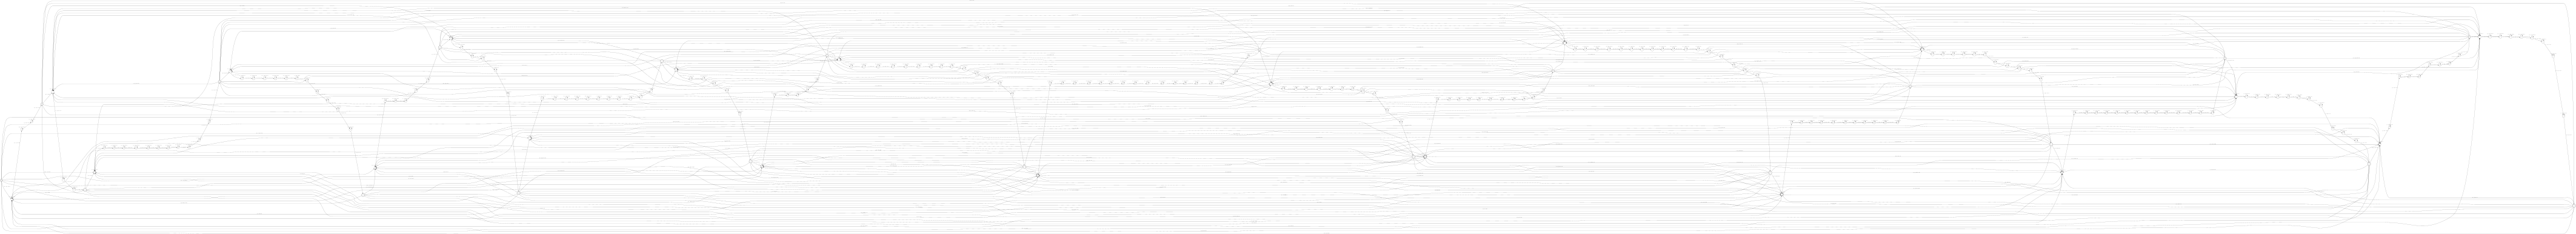

In [32]:
#Changed this for finding the memory of each model (change f=... accordingly)
f = create_wfst_bigram(0.5, 0.2625, 0.5)

arc_count = count_arcs(f)
print(arc_count)
print(f.num_states())

from subprocess import check_call
from IPython.display import Image
f.draw('asdf.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=500','asdf.dot','-o','asdf.png'])
Image(filename='asdf.png')

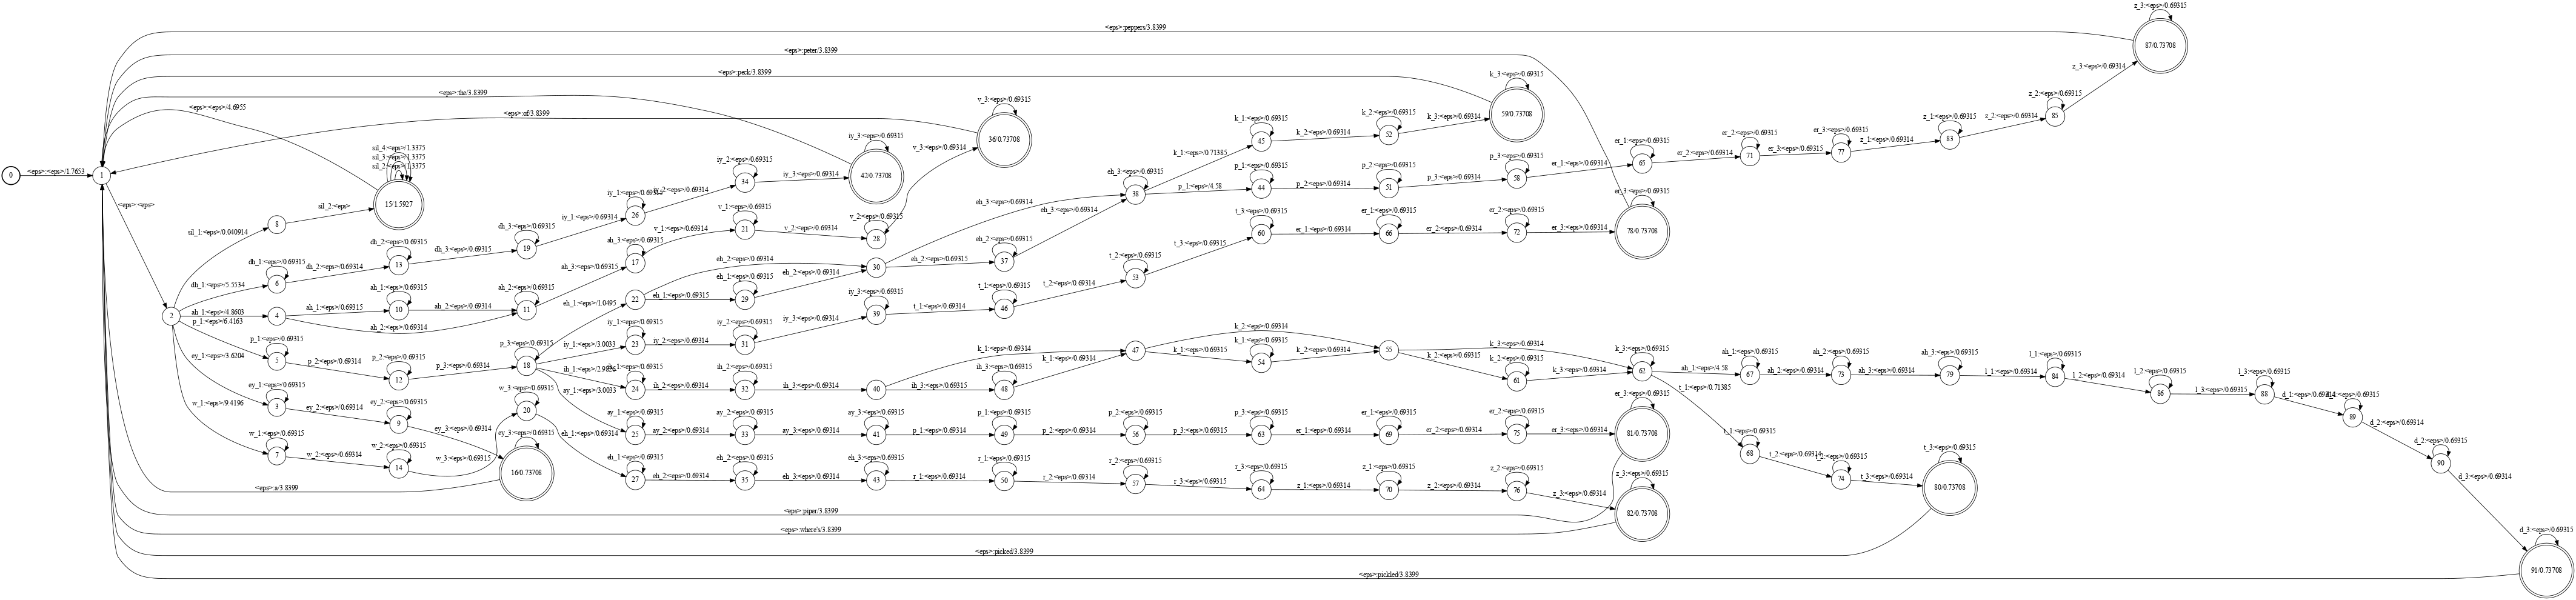

In [79]:
f = create_wfst_unigram_silent(0.5, 0.2625, 0.5) #f = fst.determinize(f) f.minimze too
f = fst.determinize(f)
f = f.minimize()
f

from subprocess import check_call
from IPython.display import Image
f.draw('nodet3.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=500','nodet3.dot','-o','nodet3.png'])
Image(filename='nodet3.png')

In [26]:
#Testing Trees BOTH DETERMINIZE AND MINIMIZE

tree_tests_determinize = {}
#for trans_weight in incomplete_finest:
#    print('New:', trans_weight)
#for width_weights in reversed(bw_values_left):
#    print('New:', width_weights)
f = create_wfst_unigram_silent(0.5, 0.2625, 0.5) #f = fst.determinize(f) f.minimze too
f = fst.determinize(f)
f.minimize()

decode_time = []
backtrace_time = []
total_WER = 0
count = 0
lengths_averages= []
f_comps_l = []

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                            # audio files


    decoder = MyViterbiDecoder(f, wav_file, 1e-41) #Added the Beam Search!! ---- Need to add beam search parameter
    decode_start_time = time.time()
    decoder.decode()
    decode_time.append(time.time() - decode_start_time)

    f_comps = decoder.forward_computations
    f_comps_l.append(f_comps)


    backtrace_start_time = time.time()
    (state_path, words) = decoder.backtrace()# you'll need to modify the backtrace() from Lab 4
                                        # to return the words along the best path
    backtrace_time.append(time.time() - backtrace_start_time)

    transcription = read_transcription(wav_file)
    #print('trans:',transcription)
    #print('words:',words)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    Substitutions = error_counts[0]
    Deletions = error_counts[1]
    Insertions = error_counts[2]

    SumWER = Substitutions + Deletions + Insertions
    WER = SumWER / word_count

    total_WER += WER
    count += 1
    averageWER = total_WER / count
#         lengths_averages[word_count][0] += 1
#         lengths_averages[word_count][1] += WER

#             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

print('WER:',averageWER)


decode_time_result = sum(decode_time) / len(decode_time)
avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
tree_tests = (averageWER, decode_time_result, avg_forward_comps)

#finer_grained.append(averageWER)
#results.append(averageWER)
#     all_wer_length = []
#     for [count, wer] in lengths_averages:
#         if count == 0:
#             all_wer_length.append(0)
#         else:
#             all_wer_length.append(wer/count)
#     print(all_wer_length)

print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
print('decode_time', sum(decode_time) / len(decode_time))
print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
print('///////////////')

WER: 0.48572607870610124
Avg Number of forward computations: 79966.5534591195
decode_time 1.591179294406243
backtrace_time 0.00023376791732116316
///////////////


## Optimising 'Pruning' ##

In [ ]:
bw_values = [pow(10, -i) for i in range(1,50)]
print(bw_values)

In [16]:
#OPTIMISING 'BEAM SEARCH'
results_left = {}
#for trans_weight in incomplete_finest:
#    print('New:', trans_weight)
for width_weights in reversed(bw_values_left):
    print('New:', width_weights)
    f = create_wfst_unigram_silent(0.5, 0.2625, 0.5) #f = fst.determinize(f) f.minimze too


    decode_time = []
    backtrace_time = []
    total_WER = 0
    count = 0
    lengths_averages= []
    f_comps_l = []

    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                                # audio files


        decoder = MyViterbiDecoder(f, wav_file, width_weights) #Added the Beam Search!! ---- Need to add beam search parameter
        decode_start_time = time.time()
        decoder.decode()
        decode_time.append(time.time() - decode_start_time)

        f_comps = decoder.forward_computations
        f_comps_l.append(f_comps)
        
        
        backtrace_start_time = time.time()
        (state_path, words) = decoder.backtrace()# you'll need to modify the backtrace() from Lab 4
                                            # to return the words along the best path
        backtrace_time.append(time.time() - backtrace_start_time)

        transcription = read_transcription(wav_file)
        #print('trans:',transcription)
        #print('words:',words)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        Substitutions = error_counts[0]
        Deletions = error_counts[1]
        Insertions = error_counts[2]

        SumWER = Substitutions + Deletions + Insertions
        WER = SumWER / word_count

        total_WER += WER
        count += 1
        averageWER = total_WER / count
    #         lengths_averages[word_count][0] += 1
    #         lengths_averages[word_count][1] += WER

#             print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

    print('WER:',averageWER)


    decode_time_result = sum(decode_time) / len(decode_time)
    avg_forward_comps = sum(f_comps_l) / len(f_comps_l)
    results_left[width_weights] = (averageWER, decode_time_result, avg_forward_comps)

    #finer_grained.append(averageWER)
    #results.append(averageWER)
    #     all_wer_length = []
    #     for [count, wer] in lengths_averages:
    #         if count == 0:
    #             all_wer_length.append(0)
    #         else:
    #             all_wer_length.append(wer/count)
    #     print(all_wer_length)

    print('Avg Number of forward computations:', sum(f_comps_l) / len(f_comps_l))
    print('decode_time', sum(decode_time) / len(decode_time))
    print('backtrace_time', sum(backtrace_time) / len(backtrace_time))
    print('///////////////')

New: 1e-23
WER: 0.4961845605991002
Avg Number of forward computations: 83928.74528301887
decode_time 1.6717045149713192
backtrace_time 0.00023828437493282295
///////////////
New: 1e-21
WER: 0.49866534326856216
Avg Number of forward computations: 79257.47169811321
decode_time 1.5785594061485626
backtrace_time 0.0002323996345951872
///////////////
New: 1e-19
WER: 0.5009318747803768
Avg Number of forward computations: 74057.9182389937
decode_time 1.4875680200708736
backtrace_time 0.0002289763036763893
///////////////
New: 1e-17
WER: 0.5039514140235565
Avg Number of forward computations: 68287.15094339622
decode_time 1.3763699239155032
backtrace_time 0.00022609878636006288
///////////////
New: 1e-15
WER: 0.5141965374207332
Avg Number of forward computations: 62000.93396226415
decode_time 1.255097581155645
backtrace_time 0.00022556946712469904
///////////////
New: 1e-13
WER: 0.5180494275527575
Avg Number of forward computations: 55146.657232704405
decode_time 1.1133520588185053
backtrace_ti

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
WER: 0.7269752999497733
Avg Number of forward computations: 13217.037735849057
decode_time 0.3083265652446627
backtrace_time 0.00018911991479261865
///////////////


In [55]:
bgs_weights = np.linspace(0.0001,0.9999, 10)

In [56]:
#Results for testing Transition Weights in the Bigram Silent Model
bigram_silent_testing = {
    0.0001: (0.7438162959250643,0,0), 
    0.11118888888888889: (0.5732713488262877,0,0), 
    0.22227777777777777: (0.5434469202643456,0,0), 
    0.33336666666666664: (0.5315670943723113,0,0), 
    0.44445555555555555: (0.5357655118753899,0,0),
    0.55554444: (0.533393633435254, 6.784704569750612, 384157.5849),
    0.66663333: (0.5309066899105748, 6.888325729460086, 384157.5849),
    0.77772222: (0.532717051210392, 6.868741911912115, 384157.5849),
    0.88881111: (0.5323541053840721, 6.797329173897797, 384157.5849),
    0.9999: (0.533717743082338, 6.93418669775597, 384157.5849)}

In [52]:
bgsilent_WERS = [value[0] for value in bigram_silent_testing.values()]
bgsilent_WERS

[0.7438162959250643,
 0.5732713488262877,
 0.5434469202643456,
 0.5315670943723113,
 0.5357655118753899,
 0.533393633435254,
 0.5309066899105748,
 0.532717051210392,
 0.5323541053840721,
 0.533717743082338]

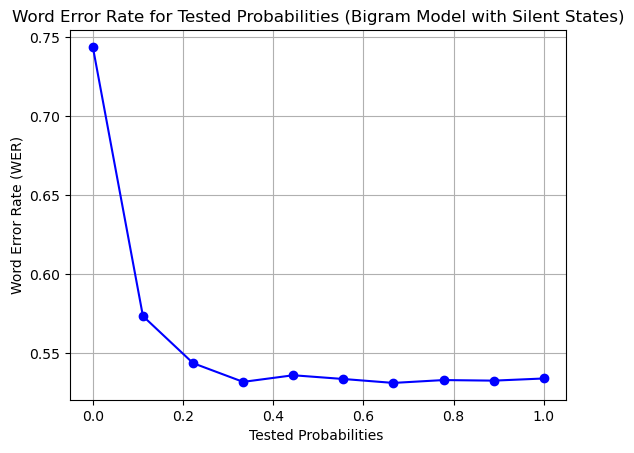

In [57]:
#Tuned Bigram with silent
import matplotlib.pyplot as plt


plt.figure()
plt.plot(bgs_weights, bgsilent_WERS, marker = 'o', linestyle = '-', color = "b")
plt.xlabel('Tested Probabilities ')
plt.ylabel('Word Error Rate (WER)')
plt.title('Word Error Rate for Tested Probabilities (Bigram Model with Silent States)')
plt.grid(True)
plt.savefig('Bigram_Silent.pdf')

plt.show()

In [51]:
#Results for testing number of silent states in 
bg_silent ={
    1: (0.6321990994577016, 5.1084552763),
    2: (0.6232965681911303, 5.445774559704763, 319126.2641509434),
    3: (0.5339052918964, 7.67116420299),
    4: (0.5744634984368612, 9.10233854572728, 517650.22641509434),
    5: (0.57446349843686, 13.4636188625539)
}

In [70]:
bgsilent_nsstates = [value[0] for value in bg_silent.values()]
bgsilent_nsstates

[0.6321990994577016,
 0.6232965681911303,
 0.5339052918964,
 0.5744634984368612,
 0.57446349843686]

In [71]:
decode_time_values = [value[1] for value in bg_silent.values()]
decode_time_values

[5.1084552763,
 5.445774559704763,
 7.67116420299,
 9.10233854572728,
 13.4636188625539]

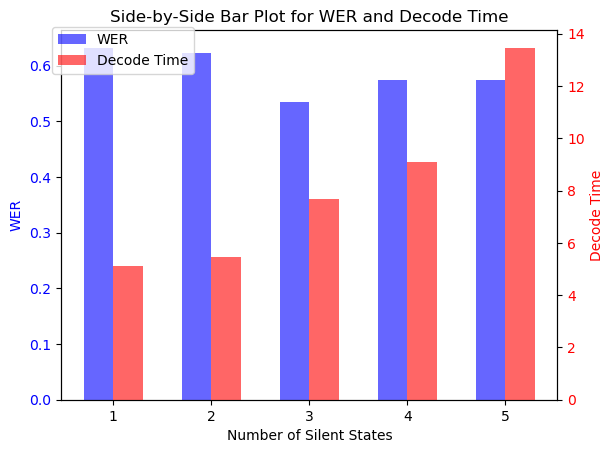

In [75]:
import matplotlib.pyplot as plt
import numpy as np

x_values = [1, 2, 3, 4, 5]

# Set bar width and positions
bar_width = 0.3
positions_wer = np.arange(len(x_values)) - bar_width/2
positions_decode_time = np.arange(len(x_values)) + bar_width/2

# Create a figure and axis for WER
fig, ax1 = plt.subplots()
ax1.bar(positions_wer, bgsilent_nsstates, width=bar_width, color='blue', alpha=0.6, label='WER')

# Set labels and color for the first y-axis (WER)
ax1.set_xlabel('Number of Silent States')
ax1.set_ylabel('WER', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Customize x-axis ticks and labels
ax1.set_xticks(np.arange(len(x_values)))
ax1.set_xticklabels(x_values)

# Create a second y-axis for Decode Time, sharing the same x-axis
ax2 = ax1.twinx()
ax2.bar(positions_decode_time, decode_time_values, width=bar_width, color='red', alpha=0.6, label='Decode Time')

# Set labels and color for the second y-axis (Decode Time)
ax2.set_ylabel('Decode Time', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title
plt.title('Side-by-Side Bar Plot for WER and Decode Time')

# Add a legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.savefig('BGSilent.pdf')

# Show the plot
plt.show()

In [76]:
#Results for testing different pruning thresholds.
results_pruning_final = {1e-51: (0.4853766726963179, 2.3510675175384907, 113256.12578616352),
 1e-49: (0.4853766726963179, 2.315854102560559, 112410.56289308176),
 1e-47: (0.4853766726963179, 2.276394987256272, 111455.56603773584),
 1e-45: (0.4853766726963179, 2.2781200926258878, 110379.38679245283),
 1e-43: (0.4853766726963179, 2.2455875821083597, 109167.23270440252),
 1e-41: (0.4853766726963179, 2.2272670224027813, 107803.33333333333),
 1e-39: (0.4872984057501264, 2.193432152646143, 106278.36163522012),
 1e-37: (0.4882464264678475, 2.1496396679548346, 104565.32075471699),
 1e-35: (0.4882464264678475, 2.0836133657011597, 102625.2389937107),
 1e-33: (0.4884883229361591, 2.043087421723132, 100443.5503144654),
 1e-31: (0.48918713495572586, 1.983819769613398, 97931.58490566038),
 1e-29: (0.489983575125085, 1.946724387834657, 95057.4465408805),
 1e-27: (0.4897826666694595, 1.9172565952037115, 91768.30188679245),
 1e-25: (0.49172060520562205, 1.810786673107987, 88056.3396226415),
 1e-23: (0.4961845605991002, 1.6717045149713192, 83928.74528301887),
 1e-21: (0.49866534326856216, 1.5785594061485626, 79257.47169811321),
 1e-19: (0.5009318747803768, 1.4875680200708736, 74057.9182389937),
 1e-17: (0.5039514140235565, 1.3763699239155032, 68287.15094339622),
 1e-15: (0.5141965374207332, 1.255097581155645, 62000.93396226415),
 1e-13: (0.5180494275527575, 1.1133520588185053, 55146.657232704405),
 1e-11: (0.5537194051067529, 0.9866920777086942, 47752.770440251574),
 1e-09: (0.583650739546966, 0.8386612065933036, 40543.874213836476),
 1e-07: (0.6135049642263846, 0.6844292819125097, 32431.96855345912),
 1e-05: (0.6608483851824587, 0.5396208620671207, 24790.311320754718),
 0.001: (0.723595471306348, 0.3976178206737686, 17798.96540880503),
 0.1: (0.7269752999497733, 0.3083265652446627, 13217.037735849057)}

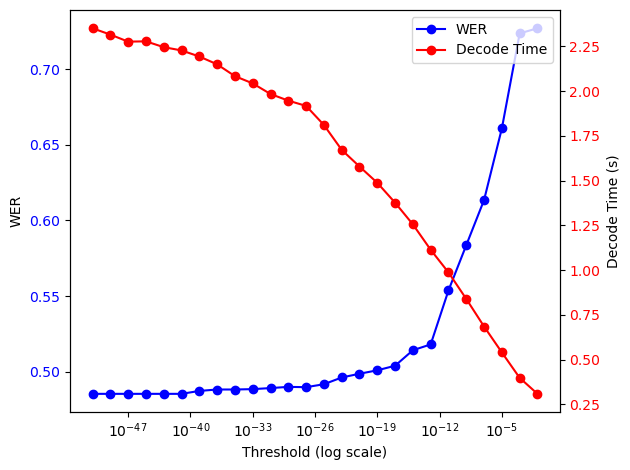

In [51]:
#Graph showing diffrent Threshold for pruning
x_values = list(results_pruning_final.keys())
y1_values = [value[0] for value in results_pruning_final.values()]
y2_values = [value[1] for value in results_pruning_final.values()]

fig, ax1 = plt.subplots()

ax1.set_xscale("log")

ax1.set_xlabel("Threshold (log scale)")
ax1.set_ylabel("WER")
ax1.plot(x_values, y1_values, label="WER", marker = 'o', linestyle = '-', color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Decode Time (s)")
ax2.plot(x_values, y2_values, label="Decode Time", marker = 'o', linestyle = '-', color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="best")

fig.tight_layout()
plt.show()

In [26]:
results_left

{1e-23: (0.4961845605991002, 1.6717045149713192, 83928.74528301887),
 1e-21: (0.49866534326856216, 1.5785594061485626, 79257.47169811321),
 1e-19: (0.5009318747803768, 1.4875680200708736, 74057.9182389937),
 1e-17: (0.5039514140235565, 1.3763699239155032, 68287.15094339622),
 1e-15: (0.5141965374207332, 1.255097581155645, 62000.93396226415),
 1e-13: (0.5180494275527575, 1.1133520588185053, 55146.657232704405),
 1e-11: (0.5537194051067529, 0.9866920777086942, 47752.770440251574),
 1e-09: (0.583650739546966, 0.8386612065933036, 40543.874213836476),
 1e-07: (0.6135049642263846, 0.6844292819125097, 32431.96855345912),
 1e-05: (0.6608483851824587, 0.5396208620671207, 24790.311320754718),
 0.001: (0.723595471306348, 0.3976178206737686, 17798.96540880503),
 0.1: (0.7269752999497733, 0.3083265652446627, 13217.037735849057)}

In [24]:
smaller_results ={1e-51: (0.4853766726963179, 2.3510675175384907, 113256.12578616352),
 1e-49: (0.4853766726963179, 2.315854102560559, 112410.56289308176),
 1e-47: (0.4853766726963179, 2.276394987256272, 111455.56603773584),
 1e-45: (0.4853766726963179, 2.2781200926258878, 110379.38679245283),
 1e-43: (0.4853766726963179, 2.2455875821083597, 109167.23270440252),
 1e-41: (0.4853766726963179, 2.2272670224027813, 107803.33333333333),
 1e-39: (0.4872984057501264, 2.193432152646143, 106278.36163522012),
 1e-37: (0.4882464264678475, 2.1496396679548346, 104565.32075471699),
 1e-35: (0.4882464264678475, 2.0836133657011597, 102625.2389937107),
 1e-33: (0.4884883229361591, 2.043087421723132, 100443.5503144654),
 1e-31: (0.48918713495572586, 1.983819769613398, 97931.58490566038),
 1e-29: (0.489983575125085, 1.946724387834657, 95057.4465408805),
 1e-27: (0.4897826666694595, 1.9172565952037115, 91768.30188679245),
 1e-25: (0.49172060520562205, 1.810786673107987, 88056.3396226415),
 1e-23: (0.4961845605991002, 1.7302488208566822, 83928.74528301887)}

In [86]:
#Average WERS over finer run with all audios. From 0.1 to 0.4.
Finest_WERS = [0.5176415683629894, 0.5148119669207354, 0.5156095415251913, 0.5124405905066288, 0.5099123884501249, 0.5021165971776411, 0.49987665507920814,
               0.495208533194105,
               0.4952453823153049,
               0.4921225294005542,
               0.49008914791378744,
               0.49103484791609125,
               0.48629232197489713,
               0.4853766726963179,
               0.48953376339613885,
               0.49127235191330676,
               0.4904877298883962,
               0.4922241162668469,
               0.4934520288155141,
               0.4965670274355072,
               0.49836800988299357,
               0.5016249730456172,
               0.5041931072175249,
               0.5037264006187427,
               0.5053758025178672,
               0.5053758025178672]
               

In [71]:
#Average WERS over whole runs with all audios. From 0.9999 to 0.0001 in the original. Reversed goes from 0.0001 to 0.9999
Full_WERS = [0.5379779369929206, 0.5337606211357601, 0.5324674852421803, 0.5249086774613969, 0.518053176, 0.5094982062, 0.4947900483, 0.4894901662, 0.5148119670, 0.5605412017]
Full_WERS.reverse()
Full_WERS

[0.5605412017,
 0.514811967,
 0.4894901662,
 0.4947900483,
 0.5094982062,
 0.518053176,
 0.5249086774613969,
 0.5324674852421803,
 0.5337606211357601,
 0.5379779369929206]

In [19]:
#list_of_WERS to find best value between 0.1 and 1e-50 - FINE GRAINED LIST OF WERS
list_of_WERS = [0.6831150793650794, 0.6852334267040149,0.597406629318394,0.6140732959850607,0.6730894024276377,0.7332773109243697,0.7601563958916899,0.7907061157796451,0.8907796451914098,0.9062558356676004,0.9383986928104576,0.9661764705882353,0.9691176470588235,0.9774509803921567,0.9803921568627452,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]


In [62]:
bigrams

{0.0001: (0.5196608120165277, 4.9699249514993635, 287142.6037735849),
 0.05564444444444445: (0.5161525001286381,
  5.027307578602677,
  287142.6037735849),
 0.11118888888888889: (0.5481300731578205,
  5.065060027740286,
  287142.6037735849),
 0.16673333333333332: (0.5616959817015313,
  5.0300984285162675,
  287142.6037735849),
 0.22227777777777777: (0.5814447817361252,
  4.968860007681936,
  287142.6037735849),
 0.2778222222222222: (0.5914929204884817,
  4.972645165785304,
  287142.6037735849),
 0.33336666666666664: (0.6016520187996331,
  5.026668861976959,
  287142.6037735849),
 0.3889111111111111: (0.6157856104720707,
  4.9927213956724925,
  287142.6037735849),
 0.44445555555555555: (0.6245330875602801,
  4.99165633339552,
  287142.6037735849),
 0.5: (0.6321990994577016, 5.034733945468687, 287142.6037735849),
 0.5555444444444444: (0.6439958497949625,
  4.665986471955881,
  287142.6037735849),
 0.6110888888888889: (0.6522124697762886,
  4.6225339774065795,
  287142.6037735849),
 0.666

In [63]:
wers_from_dict = [value[0] for value in bigrams.values()]
wers_from_dict

[0.5196608120165277,
 0.5161525001286381,
 0.5481300731578205,
 0.5616959817015313,
 0.5814447817361252,
 0.5914929204884817,
 0.6016520187996331,
 0.6157856104720707,
 0.6245330875602801,
 0.6321990994577016,
 0.6439958497949625,
 0.6522124697762886,
 0.6629816621492544,
 0.6736950952406008,
 0.681718587656435,
 0.6896934128066207,
 0.7051050072137754,
 0.7136131569955099,
 0.7203170544874207]

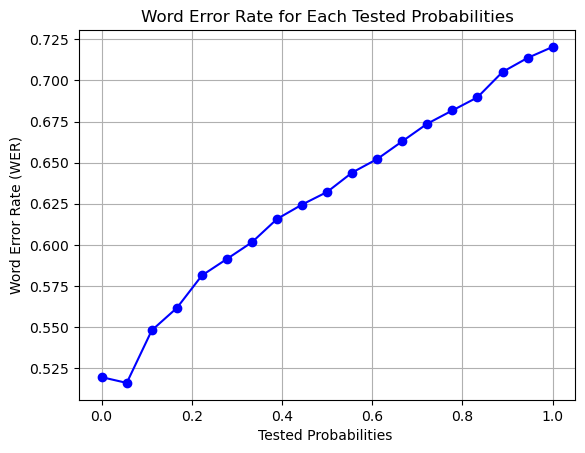

In [65]:
#Tuned Bigram graph (No Silent)
import matplotlib.pyplot as plt


plt.figure()
plt.plot(bigram_test_weights, wers_from_dict, marker = 'o', linestyle = '-', color = "b")
plt.xlabel('Tested Probabilities ')
plt.ylabel('Word Error Rate (WER)')
plt.title('Word Error Rate for Each Tested Probabilities')
plt.grid(True)
plt.savefig('Bigram.pdf')

plt.show()

In [69]:
tw = []

for trans_weight in np.linspace(0.0001, 0.9999, 10):
    tw.append(trans_weight)
tw

[0.0001,
 0.11118888888888889,
 0.22227777777777777,
 0.33336666666666664,
 0.44445555555555555,
 0.5555444444444444,
 0.6666333333333333,
 0.7777222222222222,
 0.8888111111111111,
 0.9999]

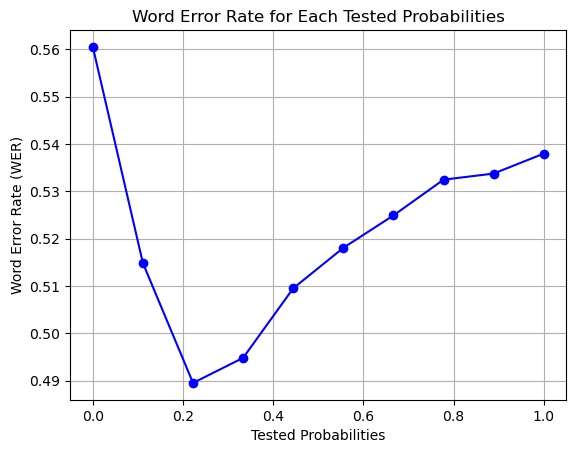

In [72]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(tw, Full_WERS, marker = 'o', linestyle = '-', color = "b")
plt.xlabel('Tested Probabilities')
plt.ylabel('Word Error Rate (WER)')
plt.title('Word Error Rate for Each Tested Probabilities')
plt.grid(True)
plt.savefig('PeakWeights.pdf')

plt.show()

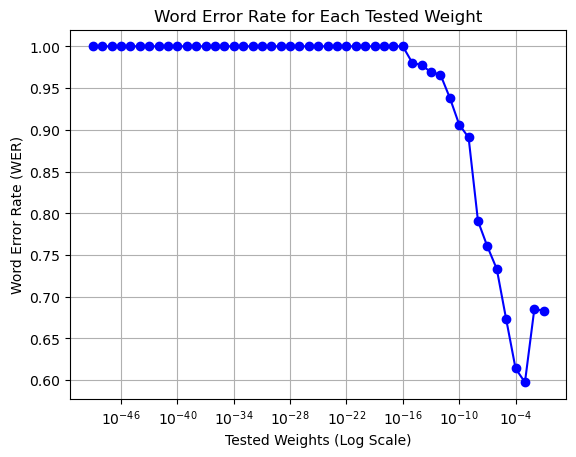

In [23]:
import matplotlib.pyplot as plt


plt.figure()
plt.semilogx(testing_weights, Full_WERS, marker = 'o', linestyle = '-', color = "b")
plt.xlabel('Tested Weights (Log Scale)')
plt.ylabel('Word Error Rate (WER)')
plt.title('Word Error Rate for Each Tested Weight')
plt.grid(True)
plt.savefig('TestedWeights.pdf')

plt.show()